# Feature Extraction from Time Series Data Using a Neural Network

Currently not using pycbc data yet as constructing the model

TODO:
- Generate simple data -> Done
- Add noise -> Done
- Build NN model for parameter estimation --> Done
- Training loop -> Done
- Testing of trained model --> Done
- Parameter Search for best model --> Done
- Update Model to do parameter prosterior prediction, look at dingo
- Update to pycbc noise
- Update to pycbc data
- Data pre-processing
- Finished?

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import itertools
import random
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [5]:
# just generating some datasets for the time being
data_samples = 2000
mean = 10
std = 3
no_time_steps = 360

amplitudes = np.random.normal(mean, std, data_samples)

time_steps = np.linspace(0,120,no_time_steps)

signals = np.array([np.sin(time_steps)*a for a in amplitudes])

# adding noise, just gaussian for the time being
noise_mean = 0
noise_std = 0.5
noised_signals = np.array([x + np.random.normal(noise_mean, noise_std, no_time_steps) for x in signals])

# convert to pytorch datasets
X = torch.FloatTensor(noised_signals)
y = torch.FloatTensor(amplitudes)

data = TensorDataset(X,y)

train_data, val_data, test_data = random_split(data, lengths=[0.8,0.1,0.1])

batch_size = 16

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)



Text(0.5, 0, 'Amplitudes')

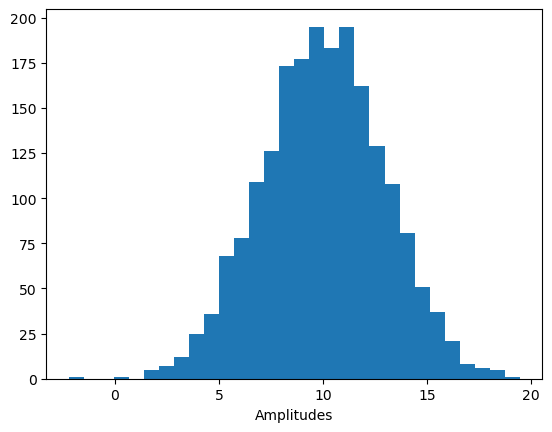

In [6]:
plt.hist(amplitudes, bins=30)
plt.xlabel("Amplitudes")

Text(0, 0.5, 'Amplitude')

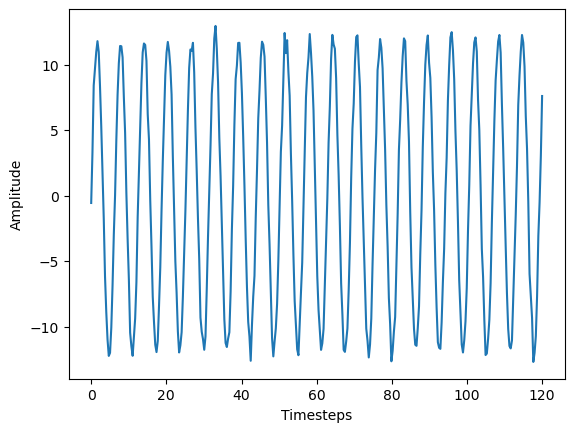

In [7]:
plt.plot(time_steps, noised_signals[0])
plt.xlabel("Timesteps")
plt.ylabel("Amplitude")

## Model

Most suggestions ive seen involve LSTM, probably worth looking into that more

In [8]:
# This initial implimentation is all from claude AI
# Going to try and get this working a bit and understand it
# And will then update

class ParameterPredictor(nn.Module):
    def __init__(self, config=None):
        super().__init__()
        
        # Default configuration
        default_config = {
            'lstm_hidden_size': 256,
            'lstm_num_layers': 1,
            'fc_layer_sizes': [128, 64],  # Sizes of fully connected layers before output
            'activation': 'silu',  # 'silu', 'relu', 'tanh'
            'dropout': 0.0,  # Dropout probability
        }
        
        # Merge with provided config
        if config is None:
            config = {}
        self.config = {**default_config, **config}
        
        # Build LSTM
        self.lstm = nn.LSTM(
            input_size=1, 
            hidden_size=self.config['lstm_hidden_size'], 
            num_layers=self.config['lstm_num_layers'], 
            batch_first=True,
            dropout=self.config['dropout'] if self.config['lstm_num_layers'] > 1 else 0.0
        )
        
        # Build fully connected layers
        fc_layers = []
        input_size = self.config['lstm_hidden_size']
        
        for hidden_size in self.config['fc_layer_sizes']:
            fc_layers.append(nn.Linear(input_size, hidden_size))
            
            # Add activation
            if self.config['activation'] == 'silu':
                fc_layers.append(nn.SiLU())
            elif self.config['activation'] == 'relu':
                fc_layers.append(nn.ReLU())
            elif self.config['activation'] == 'tanh':
                fc_layers.append(nn.Tanh())
            
            # Add dropout if specified
            if self.config['dropout'] > 0:
                fc_layers.append(nn.Dropout(self.config['dropout']))
            
            input_size = hidden_size
        
        # Output layer
        fc_layers.append(nn.Linear(input_size, 1))
        
        self.fc = nn.Sequential(*fc_layers)
    
    def forward(self, x):
        # Reshape input to [batch, sequence, features]
        x = x.unsqueeze(-1)  # Add feature dimension: [batch, 4000, 1]
        lstm_out, _ = self.lstm(x)
        # Use last output for prediction
        last_out = lstm_out[:, -1, :]
        return self.fc(last_out).squeeze(-1)

# Training Loop
Updated from code I wrote for the DSML Exam

In [9]:
def train_model(model, optimizer, loss_fcn, n_epochs, train_dloader, val_dloader, start_epoch = 0, patience = 8, scheduler=None, save_best_model=False, model_path='best_model.pt'):
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []
    best_val_loss = float('inf')
    best_val_epoch = 0

    for epoch in range(start_epoch, start_epoch + n_epochs):
        model.train()
        tloss, vloss = 0, 0
        train_predictions = []
        train_targets = []

        for X_train, y_train in tqdm(train_dloader, desc='Epoch {}, training'.format(epoch+1)):
            optimizer.zero_grad()
            pred = model(X_train)
            loss = loss_fcn(pred, y_train.flatten())            
            tloss += loss.item()
            loss.backward()
            optimizer.step()
            
            train_predictions.extend(pred.detach().numpy())
            train_targets.extend(y_train.flatten().numpy())

            
        model.eval()
        vloss = 0
        val_predictions = []
        val_targets = []

        with torch.no_grad():
            vtrue_preds, vcount = 0., 0
            for X_valid, y_valid in tqdm(val_dloader, desc='Epoch {}, validation'.format(epoch+1)):
                pred = model(X_valid)
                loss = loss_fcn(pred, y_valid.flatten())
                vloss += loss.item()


                val_predictions.extend(pred.numpy())
                val_targets.extend(y_valid.flatten().numpy())

        # Calculate metrics
        train_metrics_dict = calculate_metrics(
            np.array(train_predictions), 
            np.array(train_targets)
        )
        val_metrics_dict = calculate_metrics(
            np.array(val_predictions), 
            np.array(val_targets)
        )

        # Store losses
        avg_train_loss = tloss / len(train_dloader)
        avg_val_loss = vloss / len(val_dloader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Store metrics
        train_metrics.append(train_metrics_dict)
        val_metrics.append(val_metrics_dict)

        # Print epoch results
        print(f"\n[Epoch {epoch+1:2d}]")
        print(f"Training - Loss: {avg_train_loss:.4f}, MAE: {train_metrics_dict['mae']:.4f}, "
              f"RMSE: {train_metrics_dict['rmse']:.4f}, R²: {train_metrics_dict['r2']:.4f}")
        print(f"Validation - Loss: {avg_val_loss:.4f}, MAE: {val_metrics_dict['mae']:.4f}, "
              f"RMSE: {val_metrics_dict['rmse']:.4f}, R²: {val_metrics_dict['r2']:.4f} \n")

        # Learning rate scheduling
        if scheduler is not None:
            scheduler.step(avg_val_loss)
            current_lr = [param_group['lr'] for param_group in optimizer.param_groups]
            print(f"Current learning rates: {current_lr}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            print("New best validation performance \n")
            best_val_loss = avg_val_loss
            best_val_epoch = epoch
            
            # Save the best model
            if save_best_model:
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_val_loss': best_val_loss,
                    'model_config': model.config if hasattr(model, 'config') else None,
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'train_metrics': train_metrics,
                    'val_metrics': val_metrics
                }
                torch.save(checkpoint, model_path)
                print(f"Model checkpoint saved to {model_path}\n")
                
        elif best_val_epoch <= epoch - patience:
            print(f'No improvement in validation loss in last {patience} epochs \n')
            break

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_metrics': train_metrics,
        'val_metrics': val_metrics,
        'best_val_loss': best_val_loss,
        'best_val_epoch': best_val_epoch
    }

def calculate_metrics(predictions, targets):
    """Calculate regression metrics for parameter estimation"""
    mae = np.mean(np.abs(predictions - targets))
    rmse = np.sqrt(np.mean((predictions - targets) ** 2))
    
    # R² score
    ss_res = np.sum((targets - predictions) ** 2)
    ss_tot = np.sum((targets - np.mean(targets)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }

def load_best_model(model_path='best_model.pt'):
    """
    Load the best saved model checkpoint.
    
    Args:
        model_path: Path to the saved model checkpoint
        
    Returns:
        model: Loaded model
        checkpoint: Full checkpoint dictionary with training history
    """
    checkpoint = torch.load(model_path)
    
    # Recreate model with saved config
    model = ParameterPredictor(checkpoint['model_config'])
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"Loaded model from {model_path}")
    print(f"  Best epoch: {checkpoint['epoch'] + 1}")
    print(f"  Best validation loss: {checkpoint['best_val_loss']:.4f}")
    
    return model, checkpoint

In [10]:
# model = ParameterPredictor()
# lossfcn = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',
#     factor=0.5,
#     patience=3,
#     min_lr=1e-6,
#     verbose=True
# )

# outputs = train_model(model, optimizer, lossfcn, 50, train_loader, val_loader, scheduler=scheduler)

In [11]:
# plt.plot(outputs['train_losses'], label='Train Loss')
# plt.plot(outputs['val_losses'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


# Hyperparameter Search

In [12]:
def hyperparameter_search(param_grid, train_loader, val_loader, n_epochs=20, n_trials=None):
    """
    Search for the best hyperparameter configuration.
    
    Args:
        param_grid: Dictionary of parameter names to lists of values to try
        train_loader: Training data loader
        val_loader: Validation data loader
        n_epochs: Number of epochs to train each configuration
        n_trials: Number of random configurations to try (None = try all combinations)
    
    Returns:
        best_config: Dictionary with the best configuration
        results: List of dictionaries with all trial results
    """

    
    results = []
    best_val_loss = float('inf')
    best_config = None
    
    # Generate all combinations or sample randomly
    param_names = list(param_grid.keys())
    param_values = [param_grid[name] for name in param_names]
    
    if n_trials is None:
        # Try all combinations (grid search)
        all_combinations = list(itertools.product(*param_values))
    else:
        # Random search: sample n_trials random combinations
        all_combinations = []
        for _ in range(n_trials):
            combo = tuple(random.choice(values) for values in param_values)
            all_combinations.append(combo)
    
    print(f"Testing {len(all_combinations)} configurations...\n")
    
    for i, combo in enumerate(all_combinations):
        # Create config dictionary
        config = dict(zip(param_names, combo))
        
        print(f"{'='*60}")
        print(f"Trial {i+1}/{len(all_combinations)}")
        print(f"Config: {config}")
        print(f"{'='*60}")
        
        # Create model with this configuration
        model = ParameterPredictor(config)
        
        # Create optimizer and scheduler
        lr = config.get('learning_rate', 0.01)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=2,
            min_lr=1e-6,
            verbose=False  # Less verbose during search
        )
        
        loss_fcn = nn.MSELoss()
        
        # Train the model
        try:
            outputs = train_model(
                model, 
                optimizer, 
                loss_fcn, 
                n_epochs, 
                train_loader, 
                val_loader, 
                patience=8,
                scheduler=scheduler
            )
            
            # Get best validation loss
            final_val_loss = min(outputs['val_losses'])
            final_val_metrics = outputs['val_metrics'][outputs['val_losses'].index(final_val_loss)]
            
            # Store results
            result = {
                'config': config.copy(),
                'best_val_loss': final_val_loss,
                'best_val_mae': final_val_metrics['mae'],
                'best_val_rmse': final_val_metrics['rmse'],
                'best_val_r2': final_val_metrics['r2'],
                'n_epochs_trained': len(outputs['val_losses'])
            }
            results.append(result)
            
            print(f"\nFinal validation loss: {final_val_loss:.4f}")
            print(f"Best validation R²: {final_val_metrics['r2']:.4f}\n")
            
            # Update best configuration
            if final_val_loss < best_val_loss:
                best_val_loss = final_val_loss
                best_config = config.copy()
                print(f"*** New best configuration found! ***\n")
        
        except Exception as e:
            print(f"Error training with config {config}: {e}\n")
            continue
    
    # Print summary
    print(f"\n{'='*60}")
    print("HYPERPARAMETER SEARCH COMPLETE")
    print(f"{'='*60}")
    print(f"\nBest configuration:")
    for key, value in best_config.items():
        print(f"  {key}: {value}")
    print(f"\nBest validation loss: {best_val_loss:.4f}")
    
    # Sort results by validation loss
    results.sort(key=lambda x: x['best_val_loss'])
    
    return best_config, results

In [16]:
# Define the hyperparameter grid
param_grid = {
    'lstm_hidden_size': [128, 256],
    'lstm_num_layers': [1],
    'fc_layer_sizes': [[128, 64], [256, 128], [64, 32]],
    'activation': ['relu'],
    'dropout': [0.0],
    'learning_rate': [0.01]
}

# Run hyperparameter search
# Use n_trials for random search (faster) or set to None for full grid search
best_config, search_results = hyperparameter_search(
    param_grid, 
    train_loader, 
    val_loader, 
    n_epochs=50,
    n_trials=None  # Try 10 random configurations (set to None to try all combinations)
)

# Display top 5 configurations
print("\nTop 5 configurations:")
for i, result in enumerate(search_results[:5]):
    print(f"\n{i+1}. Val Loss: {result['best_val_loss']:.4f}, R²: {result['best_val_r2']:.4f}")
    print(f"   Config: {result['config']}")

Testing 6 configurations...

Trial 1/6
Config: {'lstm_hidden_size': 128, 'lstm_num_layers': 1, 'fc_layer_sizes': [128, 64], 'activation': 'relu', 'dropout': 0.0, 'learning_rate': 0.01}


Epoch 1, validation: 100%|██████████| 13/13 [00:00<00:00, 133.56it/s]



[Epoch  1]
Training - Loss: 12.8847, MAE: 2.7096, RMSE: 3.5895, R²: -0.4932
Validation - Loss: 8.9455, MAE: 2.3597, RMSE: 2.9833, R²: -0.0423 

Current learning rates: [0.01]
New best validation performance 



Epoch 2, validation: 100%|██████████| 13/13 [00:00<00:00, 131.67it/s]



[Epoch  2]
Training - Loss: 5.8048, MAE: 1.8551, RMSE: 2.4093, R²: 0.3273
Validation - Loss: 0.8459, MAE: 0.7424, RMSE: 0.9283, R²: 0.8991 

Current learning rates: [0.01]
New best validation performance 



Epoch 3, validation: 100%|██████████| 13/13 [00:00<00:00, 144.83it/s]



[Epoch  3]
Training - Loss: 1.0527, MAE: 0.8290, RMSE: 1.0260, R²: 0.8780
Validation - Loss: 0.7237, MAE: 0.6738, RMSE: 0.8652, R²: 0.9123 

Current learning rates: [0.01]
New best validation performance 



Epoch 4, validation: 100%|██████████| 13/13 [00:00<00:00, 127.79it/s]



[Epoch  4]
Training - Loss: 0.9191, MAE: 0.7700, RMSE: 0.9587, R²: 0.8935
Validation - Loss: 0.9906, MAE: 0.8110, RMSE: 1.0072, R²: 0.8812 

Current learning rates: [0.01]


Epoch 5, validation: 100%|██████████| 13/13 [00:00<00:00, 126.55it/s]



[Epoch  5]
Training - Loss: 0.9263, MAE: 0.7592, RMSE: 0.9624, R²: 0.8927
Validation - Loss: 2.6337, MAE: 1.4859, RMSE: 1.6355, R²: 0.6867 

Current learning rates: [0.01]


Epoch 6, validation: 100%|██████████| 13/13 [00:00<00:00, 134.38it/s]



[Epoch  6]
Training - Loss: 1.0741, MAE: 0.8272, RMSE: 1.0364, R²: 0.8755
Validation - Loss: 0.4863, MAE: 0.5699, RMSE: 0.7041, R²: 0.9419 

Current learning rates: [0.01]
New best validation performance 



Epoch 7, validation: 100%|██████████| 13/13 [00:00<00:00, 134.38it/s]



[Epoch  7]
Training - Loss: 0.6364, MAE: 0.6209, RMSE: 0.7977, R²: 0.9263
Validation - Loss: 0.4824, MAE: 0.5427, RMSE: 0.7061, R²: 0.9416 

Current learning rates: [0.01]
New best validation performance 



Epoch 8, validation: 100%|██████████| 13/13 [00:00<00:00, 125.33it/s]



[Epoch  8]
Training - Loss: 0.6401, MAE: 0.6370, RMSE: 0.8001, R²: 0.9258
Validation - Loss: 0.9922, MAE: 0.8377, RMSE: 1.0051, R²: 0.8817 

Current learning rates: [0.01]


Epoch 9, validation: 100%|██████████| 13/13 [00:00<00:00, 95.84it/s]



[Epoch  9]
Training - Loss: 0.4823, MAE: 0.5420, RMSE: 0.6944, R²: 0.9441
Validation - Loss: 0.7460, MAE: 0.6883, RMSE: 0.8700, R²: 0.9114 

Current learning rates: [0.01]


Epoch 10, validation: 100%|██████████| 13/13 [00:00<00:00, 126.55it/s]



[Epoch 10]
Training - Loss: 0.6191, MAE: 0.6189, RMSE: 0.7868, R²: 0.9283
Validation - Loss: 0.4359, MAE: 0.5068, RMSE: 0.6708, R²: 0.9473 

Current learning rates: [0.01]
New best validation performance 



Epoch 11, validation: 100%|██████████| 13/13 [00:00<00:00, 126.55it/s]



[Epoch 11]
Training - Loss: 0.3670, MAE: 0.4738, RMSE: 0.6058, R²: 0.9575
Validation - Loss: 0.4718, MAE: 0.5713, RMSE: 0.6866, R²: 0.9448 

Current learning rates: [0.01]


Epoch 12, validation: 100%|██████████| 13/13 [00:00<00:00, 129.06it/s]



[Epoch 12]
Training - Loss: 0.3477, MAE: 0.4609, RMSE: 0.5897, R²: 0.9597
Validation - Loss: 0.2460, MAE: 0.3809, RMSE: 0.5013, R²: 0.9706 

Current learning rates: [0.01]
New best validation performance 



Epoch 13, validation: 100%|██████████| 13/13 [00:00<00:00, 101.83it/s]



[Epoch 13]
Training - Loss: 0.3148, MAE: 0.4366, RMSE: 0.5611, R²: 0.9635
Validation - Loss: 0.5327, MAE: 0.6113, RMSE: 0.7285, R²: 0.9378 

Current learning rates: [0.01]


Epoch 14, validation: 100%|██████████| 13/13 [00:00<00:00, 122.97it/s]



[Epoch 14]
Training - Loss: 0.3027, MAE: 0.4289, RMSE: 0.5502, R²: 0.9649
Validation - Loss: 0.4579, MAE: 0.5757, RMSE: 0.6721, R²: 0.9471 

Current learning rates: [0.01]


Epoch 15, validation: 100%|██████████| 13/13 [00:00<00:00, 130.35it/s]



[Epoch 15]
Training - Loss: 0.3216, MAE: 0.4492, RMSE: 0.5671, R²: 0.9627
Validation - Loss: 0.2285, MAE: 0.3671, RMSE: 0.4787, R²: 0.9732 

Current learning rates: [0.01]
New best validation performance 



Epoch 16, validation: 100%|██████████| 13/13 [00:00<00:00, 126.55it/s]



[Epoch 16]
Training - Loss: 0.3055, MAE: 0.4372, RMSE: 0.5527, R²: 0.9646
Validation - Loss: 0.8642, MAE: 0.8427, RMSE: 0.9247, R²: 0.8999 

Current learning rates: [0.01]


Epoch 17, validation: 100%|██████████| 13/13 [00:00<00:00, 106.84it/s]



[Epoch 17]
Training - Loss: 0.4592, MAE: 0.5450, RMSE: 0.6777, R²: 0.9468
Validation - Loss: 0.3113, MAE: 0.4529, RMSE: 0.5659, R²: 0.9625 

Current learning rates: [0.01]


Epoch 18, validation: 100%|██████████| 13/13 [00:00<00:00, 127.79it/s]



[Epoch 18]
Training - Loss: 0.3485, MAE: 0.4776, RMSE: 0.5904, R²: 0.9596
Validation - Loss: 0.3720, MAE: 0.5087, RMSE: 0.6035, R²: 0.9573 

Current learning rates: [0.005]


Epoch 19, validation: 100%|██████████| 13/13 [00:00<00:00, 133.01it/s]



[Epoch 19]
Training - Loss: 0.2281, MAE: 0.3753, RMSE: 0.4776, R²: 0.9736
Validation - Loss: 0.1817, MAE: 0.3190, RMSE: 0.4304, R²: 0.9783 

Current learning rates: [0.005]
New best validation performance 



Epoch 20, validation: 100%|██████████| 13/13 [00:00<00:00, 131.66it/s]



[Epoch 20]
Training - Loss: 0.1644, MAE: 0.3122, RMSE: 0.4055, R²: 0.9809
Validation - Loss: 0.1859, MAE: 0.3336, RMSE: 0.4288, R²: 0.9785 

Current learning rates: [0.005]


Epoch 21, validation: 100%|██████████| 13/13 [00:00<00:00, 110.46it/s]



[Epoch 21]
Training - Loss: 0.1921, MAE: 0.3445, RMSE: 0.4383, R²: 0.9777
Validation - Loss: 0.1547, MAE: 0.2902, RMSE: 0.3974, R²: 0.9815 

Current learning rates: [0.005]
New best validation performance 



Epoch 22, validation: 100%|██████████| 13/13 [00:00<00:00, 125.33it/s]



[Epoch 22]
Training - Loss: 0.1729, MAE: 0.3264, RMSE: 0.4158, R²: 0.9800
Validation - Loss: 0.1465, MAE: 0.3021, RMSE: 0.3799, R²: 0.9831 

Current learning rates: [0.005]
New best validation performance 



Epoch 23, validation: 100%|██████████| 13/13 [00:00<00:00, 131.66it/s]



[Epoch 23]
Training - Loss: 0.1987, MAE: 0.3491, RMSE: 0.4458, R²: 0.9770
Validation - Loss: 0.1372, MAE: 0.2736, RMSE: 0.3733, R²: 0.9837 

Current learning rates: [0.005]
New best validation performance 



Epoch 24, validation: 100%|██████████| 13/13 [00:00<00:00, 134.34it/s]



[Epoch 24]
Training - Loss: 0.1516, MAE: 0.3010, RMSE: 0.3893, R²: 0.9824
Validation - Loss: 0.1214, MAE: 0.2638, RMSE: 0.3498, R²: 0.9857 

Current learning rates: [0.005]
New best validation performance 



Epoch 25, validation: 100%|██████████| 13/13 [00:00<00:00, 124.14it/s]



[Epoch 25]
Training - Loss: 0.1758, MAE: 0.3282, RMSE: 0.4193, R²: 0.9796
Validation - Loss: 0.1720, MAE: 0.3329, RMSE: 0.4180, R²: 0.9795 

Current learning rates: [0.005]


Epoch 26, validation: 100%|██████████| 13/13 [00:00<00:00, 125.34it/s]



[Epoch 26]
Training - Loss: 0.2509, MAE: 0.3986, RMSE: 0.5009, R²: 0.9709
Validation - Loss: 0.1398, MAE: 0.2906, RMSE: 0.3728, R²: 0.9837 

Current learning rates: [0.005]


Epoch 27, validation: 100%|██████████| 13/13 [00:00<00:00, 129.91it/s]



[Epoch 27]
Training - Loss: 0.1751, MAE: 0.3316, RMSE: 0.4185, R²: 0.9797
Validation - Loss: 0.1225, MAE: 0.2681, RMSE: 0.3520, R²: 0.9855 

Current learning rates: [0.0025]


Epoch 28, validation: 100%|██████████| 13/13 [00:00<00:00, 137.17it/s]



[Epoch 28]
Training - Loss: 0.1524, MAE: 0.3041, RMSE: 0.3904, R²: 0.9823
Validation - Loss: 0.1105, MAE: 0.2580, RMSE: 0.3324, R²: 0.9871 

Current learning rates: [0.0025]
New best validation performance 



Epoch 29, validation: 100%|██████████| 13/13 [00:00<00:00, 131.63it/s]



[Epoch 29]
Training - Loss: 0.1203, MAE: 0.2679, RMSE: 0.3468, R²: 0.9861
Validation - Loss: 0.1387, MAE: 0.2973, RMSE: 0.3702, R²: 0.9839 

Current learning rates: [0.0025]


Epoch 30, validation: 100%|██████████| 13/13 [00:00<00:00, 100.25it/s]



[Epoch 30]
Training - Loss: 0.1278, MAE: 0.2758, RMSE: 0.3575, R²: 0.9852
Validation - Loss: 0.1070, MAE: 0.2573, RMSE: 0.3237, R²: 0.9877 

Current learning rates: [0.0025]
New best validation performance 



Epoch 31, validation: 100%|██████████| 13/13 [00:00<00:00, 132.96it/s]



[Epoch 31]
Training - Loss: 0.1331, MAE: 0.2836, RMSE: 0.3648, R²: 0.9846
Validation - Loss: 0.1141, MAE: 0.2565, RMSE: 0.3407, R²: 0.9864 

Current learning rates: [0.0025]


Epoch 32, validation: 100%|██████████| 13/13 [00:00<00:00, 127.79it/s]



[Epoch 32]
Training - Loss: 0.1380, MAE: 0.2908, RMSE: 0.3715, R²: 0.9840
Validation - Loss: 0.1117, MAE: 0.2623, RMSE: 0.3319, R²: 0.9871 

Current learning rates: [0.0025]


Epoch 33, validation: 100%|██████████| 13/13 [00:00<00:00, 122.97it/s]



[Epoch 33]
Training - Loss: 0.1125, MAE: 0.2587, RMSE: 0.3355, R²: 0.9870
Validation - Loss: 0.1319, MAE: 0.2866, RMSE: 0.3604, R²: 0.9848 

Current learning rates: [0.00125]


Epoch 34, validation: 100%|██████████| 13/13 [00:00<00:00, 100.27it/s]



[Epoch 34]
Training - Loss: 0.1016, MAE: 0.2420, RMSE: 0.3188, R²: 0.9882
Validation - Loss: 0.0834, MAE: 0.2267, RMSE: 0.2885, R²: 0.9902 

Current learning rates: [0.00125]
New best validation performance 



Epoch 35, validation: 100%|██████████| 13/13 [00:00<00:00, 117.43it/s]



[Epoch 35]
Training - Loss: 0.0887, MAE: 0.2258, RMSE: 0.2979, R²: 0.9897
Validation - Loss: 0.0932, MAE: 0.2352, RMSE: 0.3081, R²: 0.9889 

Current learning rates: [0.00125]


Epoch 36, validation: 100%|██████████| 13/13 [00:00<00:00, 126.55it/s]



[Epoch 36]
Training - Loss: 0.0851, MAE: 0.2239, RMSE: 0.2917, R²: 0.9901
Validation - Loss: 0.0876, MAE: 0.2420, RMSE: 0.2950, R²: 0.9898 

Current learning rates: [0.00125]


Epoch 37, validation: 100%|██████████| 13/13 [00:00<00:00, 118.50it/s]



[Epoch 37]
Training - Loss: 0.0763, MAE: 0.2114, RMSE: 0.2762, R²: 0.9912
Validation - Loss: 0.0665, MAE: 0.2081, RMSE: 0.2581, R²: 0.9922 

Current learning rates: [0.00125]
New best validation performance 



Epoch 38, validation: 100%|██████████| 13/13 [00:00<00:00, 125.34it/s]



[Epoch 38]
Training - Loss: 0.0834, MAE: 0.2193, RMSE: 0.2887, R²: 0.9903
Validation - Loss: 0.0617, MAE: 0.1977, RMSE: 0.2496, R²: 0.9927 

Current learning rates: [0.00125]
New best validation performance 



Epoch 39, validation: 100%|██████████| 13/13 [00:00<00:00, 125.33it/s]



[Epoch 39]
Training - Loss: 0.0778, MAE: 0.2133, RMSE: 0.2789, R²: 0.9910
Validation - Loss: 0.0765, MAE: 0.2248, RMSE: 0.2764, R²: 0.9911 

Current learning rates: [0.00125]


Epoch 40, validation: 100%|██████████| 13/13 [00:00<00:00, 131.66it/s]



[Epoch 40]
Training - Loss: 0.0802, MAE: 0.2176, RMSE: 0.2833, R²: 0.9907
Validation - Loss: 0.0612, MAE: 0.1993, RMSE: 0.2475, R²: 0.9928 

Current learning rates: [0.00125]
New best validation performance 



Epoch 41, validation: 100%|██████████| 13/13 [00:00<00:00, 130.35it/s]



[Epoch 41]
Training - Loss: 0.0767, MAE: 0.2142, RMSE: 0.2769, R²: 0.9911
Validation - Loss: 0.0583, MAE: 0.1912, RMSE: 0.2423, R²: 0.9931 

Current learning rates: [0.00125]
New best validation performance 



Epoch 42, validation: 100%|██████████| 13/13 [00:00<00:00, 105.97it/s]



[Epoch 42]
Training - Loss: 0.0767, MAE: 0.2131, RMSE: 0.2769, R²: 0.9911
Validation - Loss: 0.0598, MAE: 0.1972, RMSE: 0.2448, R²: 0.9930 

Current learning rates: [0.00125]


Epoch 43, validation: 100%|██████████| 13/13 [00:00<00:00, 133.01it/s]



[Epoch 43]
Training - Loss: 0.0728, MAE: 0.2066, RMSE: 0.2698, R²: 0.9916
Validation - Loss: 0.0609, MAE: 0.1935, RMSE: 0.2489, R²: 0.9927 

Current learning rates: [0.00125]


Epoch 44, validation: 100%|██████████| 13/13 [00:00<00:00, 120.66it/s]



[Epoch 44]
Training - Loss: 0.0682, MAE: 0.2012, RMSE: 0.2611, R²: 0.9921
Validation - Loss: 0.0587, MAE: 0.1936, RMSE: 0.2427, R²: 0.9931 

Current learning rates: [0.000625]


Epoch 45, validation: 100%|██████████| 13/13 [00:00<00:00, 129.06it/s]



[Epoch 45]
Training - Loss: 0.0610, MAE: 0.1899, RMSE: 0.2469, R²: 0.9929
Validation - Loss: 0.0547, MAE: 0.1859, RMSE: 0.2348, R²: 0.9935 

Current learning rates: [0.000625]
New best validation performance 



Epoch 46, validation: 100%|██████████| 13/13 [00:00<00:00, 131.66it/s]



[Epoch 46]
Training - Loss: 0.0645, MAE: 0.1931, RMSE: 0.2540, R²: 0.9925
Validation - Loss: 0.0788, MAE: 0.2254, RMSE: 0.2810, R²: 0.9908 

Current learning rates: [0.000625]


Epoch 47, validation: 100%|██████████| 13/13 [00:00<00:00, 121.82it/s]



[Epoch 47]
Training - Loss: 0.0648, MAE: 0.1946, RMSE: 0.2546, R²: 0.9925
Validation - Loss: 0.0575, MAE: 0.1892, RMSE: 0.2405, R²: 0.9932 

Current learning rates: [0.000625]


Epoch 48, validation: 100%|██████████| 13/13 [00:00<00:00, 125.33it/s]



[Epoch 48]
Training - Loss: 0.0655, MAE: 0.1952, RMSE: 0.2559, R²: 0.9924
Validation - Loss: 0.0694, MAE: 0.2101, RMSE: 0.2660, R²: 0.9917 

Current learning rates: [0.0003125]


Epoch 49, validation: 100%|██████████| 13/13 [00:00<00:00, 139.67it/s]



[Epoch 49]
Training - Loss: 0.0601, MAE: 0.1879, RMSE: 0.2452, R²: 0.9930
Validation - Loss: 0.0569, MAE: 0.1891, RMSE: 0.2394, R²: 0.9933 

Current learning rates: [0.0003125]


Epoch 50, validation: 100%|██████████| 13/13 [00:00<00:00, 103.45it/s]



[Epoch 50]
Training - Loss: 0.0582, MAE: 0.1820, RMSE: 0.2412, R²: 0.9933
Validation - Loss: 0.0551, MAE: 0.1847, RMSE: 0.2359, R²: 0.9935 

Current learning rates: [0.0003125]

Final validation loss: 0.0547
Best validation R²: 0.9935

*** New best configuration found! ***

Trial 2/6
Config: {'lstm_hidden_size': 128, 'lstm_num_layers': 1, 'fc_layer_sizes': [256, 128], 'activation': 'relu', 'dropout': 0.0, 'learning_rate': 0.01}


Epoch 1, validation: 100%|██████████| 13/13 [00:00<00:00, 140.16it/s]



[Epoch  1]
Training - Loss: 14.4966, MAE: 2.3873, RMSE: 3.8074, R²: -0.6800
Validation - Loss: 0.5386, MAE: 0.5821, RMSE: 0.7457, R²: 0.9349 

Current learning rates: [0.01]
New best validation performance 



Epoch 2, validation: 100%|██████████| 13/13 [00:00<00:00, 135.78it/s]



[Epoch  2]
Training - Loss: 0.3595, MAE: 0.4694, RMSE: 0.5996, R²: 0.9583
Validation - Loss: 0.2123, MAE: 0.3691, RMSE: 0.4645, R²: 0.9747 

Current learning rates: [0.01]
New best validation performance 



Epoch 3, validation: 100%|██████████| 13/13 [00:00<00:00, 135.78it/s]



[Epoch  3]
Training - Loss: 0.3102, MAE: 0.4406, RMSE: 0.5570, R²: 0.9640
Validation - Loss: 0.1959, MAE: 0.3532, RMSE: 0.4432, R²: 0.9770 

Current learning rates: [0.01]
New best validation performance 



Epoch 4, validation: 100%|██████████| 13/13 [00:00<00:00, 131.67it/s]



[Epoch  4]
Training - Loss: 0.2230, MAE: 0.3733, RMSE: 0.4723, R²: 0.9742
Validation - Loss: 0.2671, MAE: 0.4297, RMSE: 0.5155, R²: 0.9689 

Current learning rates: [0.01]


Epoch 5, validation: 100%|██████████| 13/13 [00:00<00:00, 131.66it/s]



[Epoch  5]
Training - Loss: 0.2025, MAE: 0.3500, RMSE: 0.4500, R²: 0.9765
Validation - Loss: 0.1184, MAE: 0.2758, RMSE: 0.3469, R²: 0.9859 

Current learning rates: [0.01]
New best validation performance 



Epoch 6, validation: 100%|██████████| 13/13 [00:00<00:00, 140.16it/s]



[Epoch  6]
Training - Loss: 0.1607, MAE: 0.3140, RMSE: 0.4009, R²: 0.9814
Validation - Loss: 0.1337, MAE: 0.2835, RMSE: 0.3663, R²: 0.9843 

Current learning rates: [0.01]


Epoch 7, validation: 100%|██████████| 13/13 [00:00<00:00, 125.33it/s]



[Epoch  7]
Training - Loss: 0.2166, MAE: 0.3667, RMSE: 0.4654, R²: 0.9749
Validation - Loss: 0.4081, MAE: 0.5504, RMSE: 0.6333, R²: 0.9530 

Current learning rates: [0.01]


Epoch 8, validation: 100%|██████████| 13/13 [00:00<00:00, 137.21it/s]



[Epoch  8]
Training - Loss: 0.2726, MAE: 0.4121, RMSE: 0.5221, R²: 0.9684
Validation - Loss: 0.2218, MAE: 0.3900, RMSE: 0.4640, R²: 0.9748 

Current learning rates: [0.005]


Epoch 9, validation: 100%|██████████| 13/13 [00:00<00:00, 140.16it/s]



[Epoch  9]
Training - Loss: 0.1119, MAE: 0.2596, RMSE: 0.3345, R²: 0.9870
Validation - Loss: 0.0721, MAE: 0.2134, RMSE: 0.2681, R²: 0.9916 

Current learning rates: [0.005]
New best validation performance 



Epoch 10, validation: 100%|██████████| 13/13 [00:00<00:00, 129.06it/s]



[Epoch 10]
Training - Loss: 0.0888, MAE: 0.2330, RMSE: 0.2980, R²: 0.9897
Validation - Loss: 0.0661, MAE: 0.1932, RMSE: 0.2564, R²: 0.9923 

Current learning rates: [0.005]
New best validation performance 



Epoch 11, validation: 100%|██████████| 13/13 [00:00<00:00, 140.16it/s]



[Epoch 11]
Training - Loss: 0.0717, MAE: 0.2119, RMSE: 0.2677, R²: 0.9917
Validation - Loss: 0.1036, MAE: 0.2573, RMSE: 0.3177, R²: 0.9882 

Current learning rates: [0.005]


Epoch 12, validation: 100%|██████████| 13/13 [00:00<00:00, 138.67it/s]



[Epoch 12]
Training - Loss: 0.0657, MAE: 0.2058, RMSE: 0.2562, R²: 0.9924
Validation - Loss: 0.0505, MAE: 0.1587, RMSE: 0.2217, R²: 0.9942 

Current learning rates: [0.005]
New best validation performance 



Epoch 13, validation: 100%|██████████| 13/13 [00:00<00:00, 135.78it/s]



[Epoch 13]
Training - Loss: 0.0817, MAE: 0.2221, RMSE: 0.2859, R²: 0.9905
Validation - Loss: 0.0451, MAE: 0.1682, RMSE: 0.2121, R²: 0.9947 

Current learning rates: [0.005]
New best validation performance 



Epoch 14, validation: 100%|██████████| 13/13 [00:00<00:00, 138.67it/s]



[Epoch 14]
Training - Loss: 0.0608, MAE: 0.1905, RMSE: 0.2466, R²: 0.9930
Validation - Loss: 0.0400, MAE: 0.1632, RMSE: 0.1978, R²: 0.9954 

Current learning rates: [0.005]
New best validation performance 



Epoch 15, validation: 100%|██████████| 13/13 [00:00<00:00, 134.38it/s]



[Epoch 15]
Training - Loss: 0.0799, MAE: 0.1961, RMSE: 0.2826, R²: 0.9907
Validation - Loss: 0.0478, MAE: 0.1584, RMSE: 0.2144, R²: 0.9946 

Current learning rates: [0.005]


Epoch 16, validation: 100%|██████████| 13/13 [00:00<00:00, 137.21it/s]



[Epoch 16]
Training - Loss: 0.0753, MAE: 0.2133, RMSE: 0.2744, R²: 0.9913
Validation - Loss: 0.0387, MAE: 0.1505, RMSE: 0.1972, R²: 0.9954 

Current learning rates: [0.005]
New best validation performance 



Epoch 17, validation: 100%|██████████| 13/13 [00:00<00:00, 137.21it/s]



[Epoch 17]
Training - Loss: 0.0616, MAE: 0.1922, RMSE: 0.2481, R²: 0.9929
Validation - Loss: 0.0299, MAE: 0.1295, RMSE: 0.1700, R²: 0.9966 

Current learning rates: [0.005]
New best validation performance 



Epoch 18, validation: 100%|██████████| 13/13 [00:00<00:00, 141.68it/s]



[Epoch 18]
Training - Loss: 0.0408, MAE: 0.1554, RMSE: 0.2019, R²: 0.9953
Validation - Loss: 0.0305, MAE: 0.1410, RMSE: 0.1724, R²: 0.9965 

Current learning rates: [0.005]


Epoch 19, validation: 100%|██████████| 13/13 [00:00<00:00, 143.24it/s]



[Epoch 19]
Training - Loss: 0.0365, MAE: 0.1481, RMSE: 0.1912, R²: 0.9958
Validation - Loss: 0.0616, MAE: 0.2086, RMSE: 0.2455, R²: 0.9929 

Current learning rates: [0.005]


Epoch 20, validation: 100%|██████████| 13/13 [00:00<00:00, 134.38it/s]



[Epoch 20]
Training - Loss: 0.0592, MAE: 0.1771, RMSE: 0.2433, R²: 0.9931
Validation - Loss: 0.0408, MAE: 0.1446, RMSE: 0.1951, R²: 0.9955 

Current learning rates: [0.0025]


Epoch 21, validation: 100%|██████████| 13/13 [00:00<00:00, 137.21it/s]



[Epoch 21]
Training - Loss: 0.0314, MAE: 0.1326, RMSE: 0.1772, R²: 0.9964
Validation - Loss: 0.0171, MAE: 0.0997, RMSE: 0.1310, R²: 0.9980 

Current learning rates: [0.0025]
New best validation performance 



Epoch 22, validation: 100%|██████████| 13/13 [00:00<00:00, 133.01it/s]



[Epoch 22]
Training - Loss: 0.0243, MAE: 0.1162, RMSE: 0.1559, R²: 0.9972
Validation - Loss: 0.0245, MAE: 0.1216, RMSE: 0.1532, R²: 0.9973 

Current learning rates: [0.0025]


Epoch 23, validation: 100%|██████████| 13/13 [00:00<00:00, 109.54it/s]



[Epoch 23]
Training - Loss: 0.0196, MAE: 0.1041, RMSE: 0.1402, R²: 0.9977
Validation - Loss: 0.0150, MAE: 0.0928, RMSE: 0.1240, R²: 0.9982 

Current learning rates: [0.0025]
New best validation performance 



Epoch 24, validation: 100%|██████████| 13/13 [00:00<00:00, 140.16it/s]



[Epoch 24]
Training - Loss: 0.0200, MAE: 0.1069, RMSE: 0.1415, R²: 0.9977
Validation - Loss: 0.0125, MAE: 0.0891, RMSE: 0.1131, R²: 0.9985 

Current learning rates: [0.0025]
New best validation performance 



Epoch 25, validation: 100%|██████████| 13/13 [00:00<00:00, 144.47it/s]



[Epoch 25]
Training - Loss: 0.0142, MAE: 0.0872, RMSE: 0.1193, R²: 0.9984
Validation - Loss: 0.0110, MAE: 0.0834, RMSE: 0.1053, R²: 0.9987 

Current learning rates: [0.0025]
New best validation performance 



Epoch 26, validation: 100%|██████████| 13/13 [00:00<00:00, 101.05it/s]



[Epoch 26]
Training - Loss: 0.0150, MAE: 0.0910, RMSE: 0.1226, R²: 0.9983
Validation - Loss: 0.0079, MAE: 0.0702, RMSE: 0.0888, R²: 0.9991 

Current learning rates: [0.0025]
New best validation performance 



Epoch 27, validation: 100%|██████████| 13/13 [00:00<00:00, 138.67it/s]



[Epoch 27]
Training - Loss: 0.0132, MAE: 0.0851, RMSE: 0.1147, R²: 0.9985
Validation - Loss: 0.0078, MAE: 0.0675, RMSE: 0.0885, R²: 0.9991 

Current learning rates: [0.0025]
New best validation performance 



Epoch 28, validation: 100%|██████████| 13/13 [00:00<00:00, 133.01it/s]



[Epoch 28]
Training - Loss: 0.0109, MAE: 0.0761, RMSE: 0.1043, R²: 0.9987
Validation - Loss: 0.0076, MAE: 0.0668, RMSE: 0.0885, R²: 0.9991 

Current learning rates: [0.0025]
New best validation performance 



Epoch 29, validation: 100%|██████████| 13/13 [00:00<00:00, 141.68it/s]



[Epoch 29]
Training - Loss: 0.0171, MAE: 0.0982, RMSE: 0.1310, R²: 0.9980
Validation - Loss: 0.0101, MAE: 0.0828, RMSE: 0.1018, R²: 0.9988 

Current learning rates: [0.0025]


Epoch 30, validation: 100%|██████████| 13/13 [00:00<00:00, 137.21it/s]



[Epoch 30]
Training - Loss: 0.0120, MAE: 0.0814, RMSE: 0.1098, R²: 0.9986
Validation - Loss: 0.0206, MAE: 0.1252, RMSE: 0.1437, R²: 0.9976 

Current learning rates: [0.0025]


Epoch 31, validation: 100%|██████████| 13/13 [00:00<00:00, 138.67it/s]



[Epoch 31]
Training - Loss: 0.0158, MAE: 0.0948, RMSE: 0.1259, R²: 0.9982
Validation - Loss: 0.0089, MAE: 0.0784, RMSE: 0.0949, R²: 0.9989 

Current learning rates: [0.00125]


Epoch 32, validation: 100%|██████████| 13/13 [00:00<00:00, 131.66it/s]



[Epoch 32]
Training - Loss: 0.0074, MAE: 0.0625, RMSE: 0.0858, R²: 0.9991
Validation - Loss: 0.0064, MAE: 0.0632, RMSE: 0.0804, R²: 0.9992 

Current learning rates: [0.00125]
New best validation performance 



Epoch 33, validation: 100%|██████████| 13/13 [00:00<00:00, 140.16it/s]



[Epoch 33]
Training - Loss: 0.0078, MAE: 0.0661, RMSE: 0.0884, R²: 0.9991
Validation - Loss: 0.0056, MAE: 0.0601, RMSE: 0.0750, R²: 0.9993 

Current learning rates: [0.00125]
New best validation performance 



Epoch 34, validation: 100%|██████████| 13/13 [00:00<00:00, 140.16it/s]



[Epoch 34]
Training - Loss: 0.0077, MAE: 0.0661, RMSE: 0.0875, R²: 0.9991
Validation - Loss: 0.0054, MAE: 0.0583, RMSE: 0.0734, R²: 0.9994 

Current learning rates: [0.00125]
New best validation performance 



Epoch 35, validation: 100%|██████████| 13/13 [00:00<00:00, 131.67it/s]



[Epoch 35]
Training - Loss: 0.0074, MAE: 0.0647, RMSE: 0.0858, R²: 0.9991
Validation - Loss: 0.0045, MAE: 0.0540, RMSE: 0.0681, R²: 0.9995 

Current learning rates: [0.00125]
New best validation performance 



Epoch 36, validation: 100%|██████████| 13/13 [00:00<00:00, 140.16it/s]



[Epoch 36]
Training - Loss: 0.0067, MAE: 0.0617, RMSE: 0.0816, R²: 0.9992
Validation - Loss: 0.0060, MAE: 0.0609, RMSE: 0.0769, R²: 0.9993 

Current learning rates: [0.00125]


Epoch 37, validation: 100%|██████████| 13/13 [00:00<00:00, 134.38it/s]



[Epoch 37]
Training - Loss: 0.0098, MAE: 0.0771, RMSE: 0.0990, R²: 0.9989
Validation - Loss: 0.0065, MAE: 0.0652, RMSE: 0.0817, R²: 0.9992 

Current learning rates: [0.00125]


Epoch 38, validation: 100%|██████████| 13/13 [00:00<00:00, 130.35it/s]



[Epoch 38]
Training - Loss: 0.0069, MAE: 0.0634, RMSE: 0.0829, R²: 0.9992
Validation - Loss: 0.0061, MAE: 0.0590, RMSE: 0.0793, R²: 0.9993 

Current learning rates: [0.000625]


Epoch 39, validation: 100%|██████████| 13/13 [00:00<00:00, 137.21it/s]



[Epoch 39]
Training - Loss: 0.0056, MAE: 0.0571, RMSE: 0.0748, R²: 0.9994
Validation - Loss: 0.0062, MAE: 0.0639, RMSE: 0.0788, R²: 0.9993 

Current learning rates: [0.000625]


Epoch 40, validation: 100%|██████████| 13/13 [00:00<00:00, 140.16it/s]



[Epoch 40]
Training - Loss: 0.0060, MAE: 0.0603, RMSE: 0.0774, R²: 0.9993
Validation - Loss: 0.0060, MAE: 0.0640, RMSE: 0.0779, R²: 0.9993 

Current learning rates: [0.000625]


Epoch 41, validation: 100%|██████████| 13/13 [00:00<00:00, 141.68it/s]



[Epoch 41]
Training - Loss: 0.0058, MAE: 0.0584, RMSE: 0.0762, R²: 0.9993
Validation - Loss: 0.0040, MAE: 0.0504, RMSE: 0.0639, R²: 0.9995 

Current learning rates: [0.000625]
New best validation performance 



Epoch 42, validation: 100%|██████████| 13/13 [00:00<00:00, 137.21it/s]



[Epoch 42]
Training - Loss: 0.0051, MAE: 0.0549, RMSE: 0.0715, R²: 0.9994
Validation - Loss: 0.0039, MAE: 0.0491, RMSE: 0.0628, R²: 0.9995 

Current learning rates: [0.000625]
New best validation performance 



Epoch 43, validation: 100%|██████████| 13/13 [00:00<00:00, 141.68it/s]



[Epoch 43]
Training - Loss: 0.0062, MAE: 0.0616, RMSE: 0.0787, R²: 0.9993
Validation - Loss: 0.0045, MAE: 0.0544, RMSE: 0.0672, R²: 0.9995 

Current learning rates: [0.000625]


Epoch 44, validation: 100%|██████████| 13/13 [00:00<00:00, 155.17it/s]



[Epoch 44]
Training - Loss: 0.0064, MAE: 0.0622, RMSE: 0.0799, R²: 0.9993
Validation - Loss: 0.0037, MAE: 0.0490, RMSE: 0.0612, R²: 0.9996 

Current learning rates: [0.000625]
New best validation performance 



Epoch 45, validation: 100%|██████████| 13/13 [00:00<00:00, 148.12it/s]



[Epoch 45]
Training - Loss: 0.0046, MAE: 0.0528, RMSE: 0.0680, R²: 0.9995
Validation - Loss: 0.0068, MAE: 0.0681, RMSE: 0.0826, R²: 0.9992 

Current learning rates: [0.000625]


Epoch 46, validation: 100%|██████████| 13/13 [00:00<00:00, 143.24it/s]



[Epoch 46]
Training - Loss: 0.0047, MAE: 0.0539, RMSE: 0.0688, R²: 0.9995
Validation - Loss: 0.0049, MAE: 0.0561, RMSE: 0.0704, R²: 0.9994 

Current learning rates: [0.000625]


Epoch 47, validation: 100%|██████████| 13/13 [00:00<00:00, 135.78it/s]



[Epoch 47]
Training - Loss: 0.0048, MAE: 0.0545, RMSE: 0.0695, R²: 0.9994
Validation - Loss: 0.0037, MAE: 0.0488, RMSE: 0.0614, R²: 0.9996 

Current learning rates: [0.0003125]


Epoch 48, validation: 100%|██████████| 13/13 [00:00<00:00, 134.38it/s]



[Epoch 48]
Training - Loss: 0.0040, MAE: 0.0492, RMSE: 0.0632, R²: 0.9995
Validation - Loss: 0.0041, MAE: 0.0519, RMSE: 0.0646, R²: 0.9995 

Current learning rates: [0.0003125]


Epoch 49, validation: 100%|██████████| 13/13 [00:00<00:00, 148.12it/s]



[Epoch 49]
Training - Loss: 0.0044, MAE: 0.0523, RMSE: 0.0663, R²: 0.9995
Validation - Loss: 0.0053, MAE: 0.0590, RMSE: 0.0728, R²: 0.9994 

Current learning rates: [0.0003125]


Epoch 50, validation: 100%|██████████| 13/13 [00:00<00:00, 144.83it/s]



[Epoch 50]
Training - Loss: 0.0045, MAE: 0.0532, RMSE: 0.0670, R²: 0.9995
Validation - Loss: 0.0039, MAE: 0.0504, RMSE: 0.0633, R²: 0.9995 

Current learning rates: [0.00015625]

Final validation loss: 0.0037
Best validation R²: 0.9996

*** New best configuration found! ***

Trial 3/6
Config: {'lstm_hidden_size': 128, 'lstm_num_layers': 1, 'fc_layer_sizes': [64, 32], 'activation': 'relu', 'dropout': 0.0, 'learning_rate': 0.01}


Epoch 1, validation: 100%|██████████| 13/13 [00:00<00:00, 137.21it/s]



[Epoch  1]
Training - Loss: 7.1932, MAE: 1.5655, RMSE: 2.6820, R²: 0.1664
Validation - Loss: 0.1635, MAE: 0.3046, RMSE: 0.4042, R²: 0.9809 

Current learning rates: [0.01]
New best validation performance 



Epoch 2, validation: 100%|██████████| 13/13 [00:00<00:00, 138.62it/s]



[Epoch  2]
Training - Loss: 0.3242, MAE: 0.4158, RMSE: 0.5694, R²: 0.9624
Validation - Loss: 0.1205, MAE: 0.2726, RMSE: 0.3464, R²: 0.9859 

Current learning rates: [0.01]
New best validation performance 



Epoch 3, validation: 100%|██████████| 13/13 [00:00<00:00, 131.66it/s]



[Epoch  3]
Training - Loss: 0.1263, MAE: 0.2760, RMSE: 0.3554, R²: 0.9854
Validation - Loss: 0.1245, MAE: 0.2904, RMSE: 0.3457, R²: 0.9860 

Current learning rates: [0.01]


Epoch 4, validation: 100%|██████████| 13/13 [00:00<00:00, 140.16it/s]



[Epoch  4]
Training - Loss: 0.2321, MAE: 0.3793, RMSE: 0.4818, R²: 0.9731
Validation - Loss: 0.0617, MAE: 0.1830, RMSE: 0.2503, R²: 0.9927 

Current learning rates: [0.01]
New best validation performance 



Epoch 5, validation: 100%|██████████| 13/13 [00:00<00:00, 135.78it/s]



[Epoch  5]
Training - Loss: 0.0940, MAE: 0.2349, RMSE: 0.3066, R²: 0.9891
Validation - Loss: 0.2687, MAE: 0.4053, RMSE: 0.5212, R²: 0.9682 

Current learning rates: [0.01]


Epoch 6, validation: 100%|██████████| 13/13 [00:00<00:00, 134.38it/s]



[Epoch  6]
Training - Loss: 0.1235, MAE: 0.2750, RMSE: 0.3515, R²: 0.9857
Validation - Loss: 0.0219, MAE: 0.1161, RMSE: 0.1484, R²: 0.9974 

Current learning rates: [0.01]
New best validation performance 



Epoch 7, validation: 100%|██████████| 13/13 [00:00<00:00, 135.78it/s]



[Epoch  7]
Training - Loss: 0.0877, MAE: 0.2327, RMSE: 0.2962, R²: 0.9898
Validation - Loss: 0.0593, MAE: 0.2114, RMSE: 0.2473, R²: 0.9928 

Current learning rates: [0.01]


Epoch 8, validation: 100%|██████████| 13/13 [00:00<00:00, 138.67it/s]



[Epoch  8]
Training - Loss: 0.0553, MAE: 0.1765, RMSE: 0.2352, R²: 0.9936
Validation - Loss: 0.0408, MAE: 0.1637, RMSE: 0.2025, R²: 0.9952 

Current learning rates: [0.01]


Epoch 9, validation: 100%|██████████| 13/13 [00:00<00:00, 141.68it/s]



[Epoch  9]
Training - Loss: 0.0787, MAE: 0.2095, RMSE: 0.2805, R²: 0.9909
Validation - Loss: 0.0727, MAE: 0.2163, RMSE: 0.2724, R²: 0.9913 

Current learning rates: [0.005]


Epoch 10, validation: 100%|██████████| 13/13 [00:00<00:00, 135.78it/s]



[Epoch 10]
Training - Loss: 0.0381, MAE: 0.1428, RMSE: 0.1952, R²: 0.9956
Validation - Loss: 0.0454, MAE: 0.1709, RMSE: 0.2121, R²: 0.9947 

Current learning rates: [0.005]


Epoch 11, validation: 100%|██████████| 13/13 [00:00<00:00, 131.62it/s]



[Epoch 11]
Training - Loss: 0.0342, MAE: 0.1373, RMSE: 0.1850, R²: 0.9960
Validation - Loss: 0.0134, MAE: 0.0898, RMSE: 0.1167, R²: 0.9984 

Current learning rates: [0.005]
New best validation performance 



Epoch 12, validation: 100%|██████████| 13/13 [00:00<00:00, 137.21it/s]



[Epoch 12]
Training - Loss: 0.0203, MAE: 0.0994, RMSE: 0.1424, R²: 0.9976
Validation - Loss: 0.0243, MAE: 0.1301, RMSE: 0.1581, R²: 0.9971 

Current learning rates: [0.005]


Epoch 13, validation: 100%|██████████| 13/13 [00:00<00:00, 98.75it/s]



[Epoch 13]
Training - Loss: 0.0178, MAE: 0.0906, RMSE: 0.1334, R²: 0.9979
Validation - Loss: 0.0094, MAE: 0.0751, RMSE: 0.0972, R²: 0.9989 

Current learning rates: [0.005]
New best validation performance 



Epoch 14, validation: 100%|██████████| 13/13 [00:00<00:00, 134.38it/s]



[Epoch 14]
Training - Loss: 0.0213, MAE: 0.1021, RMSE: 0.1459, R²: 0.9975
Validation - Loss: 0.0127, MAE: 0.0808, RMSE: 0.1142, R²: 0.9985 

Current learning rates: [0.005]


Epoch 15, validation: 100%|██████████| 13/13 [00:00<00:00, 117.43it/s]



[Epoch 15]
Training - Loss: 0.0178, MAE: 0.0934, RMSE: 0.1335, R²: 0.9979
Validation - Loss: 0.0192, MAE: 0.1123, RMSE: 0.1389, R²: 0.9977 

Current learning rates: [0.005]


Epoch 16, validation: 100%|██████████| 13/13 [00:00<00:00, 131.31it/s]



[Epoch 16]
Training - Loss: 0.0201, MAE: 0.0997, RMSE: 0.1418, R²: 0.9977
Validation - Loss: 0.0125, MAE: 0.0918, RMSE: 0.1130, R²: 0.9985 

Current learning rates: [0.0025]


Epoch 17, validation: 100%|██████████| 13/13 [00:00<00:00, 130.35it/s]



[Epoch 17]
Training - Loss: 0.0121, MAE: 0.0703, RMSE: 0.1098, R²: 0.9986
Validation - Loss: 0.0053, MAE: 0.0594, RMSE: 0.0730, R²: 0.9994 

Current learning rates: [0.0025]
New best validation performance 



Epoch 18, validation: 100%|██████████| 13/13 [00:00<00:00, 131.66it/s]



[Epoch 18]
Training - Loss: 0.0132, MAE: 0.0767, RMSE: 0.1148, R²: 0.9985
Validation - Loss: 0.0097, MAE: 0.0784, RMSE: 0.0998, R²: 0.9988 

Current learning rates: [0.0025]


Epoch 19, validation: 100%|██████████| 13/13 [00:00<00:00, 137.21it/s]



[Epoch 19]
Training - Loss: 0.0135, MAE: 0.0775, RMSE: 0.1163, R²: 0.9984
Validation - Loss: 0.0110, MAE: 0.0826, RMSE: 0.1061, R²: 0.9987 

Current learning rates: [0.0025]


Epoch 20, validation: 100%|██████████| 13/13 [00:00<00:00, 130.35it/s]



[Epoch 20]
Training - Loss: 0.0123, MAE: 0.0719, RMSE: 0.1107, R²: 0.9986
Validation - Loss: 0.0051, MAE: 0.0579, RMSE: 0.0713, R²: 0.9994 

Current learning rates: [0.0025]
New best validation performance 



Epoch 21, validation: 100%|██████████| 13/13 [00:00<00:00, 135.78it/s]



[Epoch 21]
Training - Loss: 0.0126, MAE: 0.0732, RMSE: 0.1123, R²: 0.9985
Validation - Loss: 0.0048, MAE: 0.0533, RMSE: 0.0699, R²: 0.9994 

Current learning rates: [0.0025]
New best validation performance 



Epoch 22, validation: 100%|██████████| 13/13 [00:00<00:00, 130.35it/s]



[Epoch 22]
Training - Loss: 0.0128, MAE: 0.0734, RMSE: 0.1132, R²: 0.9985
Validation - Loss: 0.0042, MAE: 0.0525, RMSE: 0.0652, R²: 0.9995 

Current learning rates: [0.0025]
New best validation performance 



Epoch 23, validation: 100%|██████████| 13/13 [00:00<00:00, 135.78it/s]



[Epoch 23]
Training - Loss: 0.0130, MAE: 0.0755, RMSE: 0.1140, R²: 0.9985
Validation - Loss: 0.0082, MAE: 0.0744, RMSE: 0.0913, R²: 0.9990 

Current learning rates: [0.0025]


Epoch 24, validation: 100%|██████████| 13/13 [00:00<00:00, 133.01it/s]



[Epoch 24]
Training - Loss: 0.0130, MAE: 0.0748, RMSE: 0.1139, R²: 0.9985
Validation - Loss: 0.0151, MAE: 0.1072, RMSE: 0.1229, R²: 0.9982 

Current learning rates: [0.0025]


Epoch 25, validation: 100%|██████████| 13/13 [00:00<00:00, 135.78it/s]



[Epoch 25]
Training - Loss: 0.0130, MAE: 0.0760, RMSE: 0.1140, R²: 0.9985
Validation - Loss: 0.0089, MAE: 0.0759, RMSE: 0.0937, R²: 0.9990 

Current learning rates: [0.00125]


Epoch 26, validation: 100%|██████████| 13/13 [00:00<00:00, 134.38it/s]



[Epoch 26]
Training - Loss: 0.0103, MAE: 0.0621, RMSE: 0.1017, R²: 0.9988
Validation - Loss: 0.0055, MAE: 0.0574, RMSE: 0.0751, R²: 0.9993 

Current learning rates: [0.00125]


Epoch 27, validation: 100%|██████████| 13/13 [00:00<00:00, 126.55it/s]



[Epoch 27]
Training - Loss: 0.0097, MAE: 0.0600, RMSE: 0.0982, R²: 0.9989
Validation - Loss: 0.0050, MAE: 0.0545, RMSE: 0.0716, R²: 0.9994 

Current learning rates: [0.00125]


Epoch 28, validation: 100%|██████████| 13/13 [00:00<00:00, 134.34it/s]



[Epoch 28]
Training - Loss: 0.0095, MAE: 0.0596, RMSE: 0.0977, R²: 0.9989
Validation - Loss: 0.0045, MAE: 0.0523, RMSE: 0.0673, R²: 0.9995 

Current learning rates: [0.000625]


Epoch 29, validation: 100%|██████████| 13/13 [00:00<00:00, 131.63it/s]



[Epoch 29]
Training - Loss: 0.0093, MAE: 0.0585, RMSE: 0.0967, R²: 0.9989
Validation - Loss: 0.0057, MAE: 0.0612, RMSE: 0.0755, R²: 0.9993 

Current learning rates: [0.000625]


Epoch 30, validation: 100%|██████████| 13/13 [00:00<00:00, 125.33it/s]



[Epoch 30]
Training - Loss: 0.0093, MAE: 0.0583, RMSE: 0.0963, R²: 0.9989
Validation - Loss: 0.0048, MAE: 0.0539, RMSE: 0.0696, R²: 0.9994 

Current learning rates: [0.000625]
No improvement in validation loss in last 8 epochs 


Final validation loss: 0.0042
Best validation R²: 0.9995

Trial 4/6
Config: {'lstm_hidden_size': 256, 'lstm_num_layers': 1, 'fc_layer_sizes': [128, 64], 'activation': 'relu', 'dropout': 0.0, 'learning_rate': 0.01}


Epoch 1, validation: 100%|██████████| 13/13 [00:00<00:00, 66.84it/s]



[Epoch  1]
Training - Loss: 11.9945, MAE: 2.6216, RMSE: 3.4633, R²: -0.3901
Validation - Loss: 4.0708, MAE: 1.5845, RMSE: 2.0176, R²: 0.5232 

Current learning rates: [0.01]
New best validation performance 



Epoch 2, validation: 100%|██████████| 13/13 [00:00<00:00, 69.33it/s]



[Epoch  2]
Training - Loss: 1.9015, MAE: 1.0826, RMSE: 1.3790, R²: 0.7796
Validation - Loss: 0.9132, MAE: 0.7625, RMSE: 0.9712, R²: 0.8895 

Current learning rates: [0.01]
New best validation performance 



Epoch 3, validation: 100%|██████████| 13/13 [00:00<00:00, 68.60it/s]



[Epoch  3]
Training - Loss: 0.8491, MAE: 0.7325, RMSE: 0.9214, R²: 0.9016
Validation - Loss: 0.7689, MAE: 0.7021, RMSE: 0.8925, R²: 0.9067 

Current learning rates: [0.01]
New best validation performance 



Epoch 4, validation: 100%|██████████| 13/13 [00:00<00:00, 65.17it/s]



[Epoch  4]
Training - Loss: 0.9409, MAE: 0.7834, RMSE: 0.9700, R²: 0.8910
Validation - Loss: 0.5738, MAE: 0.6245, RMSE: 0.7696, R²: 0.9306 

Current learning rates: [0.01]
New best validation performance 



Epoch 5, validation: 100%|██████████| 13/13 [00:00<00:00, 67.89it/s]



[Epoch  5]
Training - Loss: 0.8218, MAE: 0.7159, RMSE: 0.9065, R²: 0.9048
Validation - Loss: 0.6058, MAE: 0.6487, RMSE: 0.7889, R²: 0.9271 

Current learning rates: [0.01]


Epoch 6, validation: 100%|██████████| 13/13 [00:00<00:00, 71.62it/s]



[Epoch  6]
Training - Loss: 0.7676, MAE: 0.7041, RMSE: 0.8761, R²: 0.9110
Validation - Loss: 0.5643, MAE: 0.6226, RMSE: 0.7614, R²: 0.9321 

Current learning rates: [0.01]
New best validation performance 



Epoch 7, validation: 100%|██████████| 13/13 [00:00<00:00, 66.50it/s]



[Epoch  7]
Training - Loss: 0.8266, MAE: 0.7180, RMSE: 0.9092, R²: 0.9042
Validation - Loss: 0.9130, MAE: 0.7949, RMSE: 0.9596, R²: 0.8922 

Current learning rates: [0.01]


Epoch 8, validation: 100%|██████████| 13/13 [00:00<00:00, 69.70it/s]



[Epoch  8]
Training - Loss: 0.7739, MAE: 0.7030, RMSE: 0.8797, R²: 0.9103
Validation - Loss: 0.6777, MAE: 0.6743, RMSE: 0.8336, R²: 0.9186 

Current learning rates: [0.01]


Epoch 9, validation: 100%|██████████| 13/13 [00:00<00:00, 70.08it/s]



[Epoch  9]
Training - Loss: 0.7693, MAE: 0.6991, RMSE: 0.8771, R²: 0.9108
Validation - Loss: 0.5402, MAE: 0.6074, RMSE: 0.7449, R²: 0.9350 

Current learning rates: [0.01]
New best validation performance 



Epoch 10, validation: 100%|██████████| 13/13 [00:00<00:00, 66.17it/s]



[Epoch 10]
Training - Loss: 0.5786, MAE: 0.6057, RMSE: 0.7606, R²: 0.9330
Validation - Loss: 0.3756, MAE: 0.5024, RMSE: 0.6214, R²: 0.9548 

Current learning rates: [0.01]
New best validation performance 



Epoch 11, validation: 100%|██████████| 13/13 [00:00<00:00, 72.01it/s]



[Epoch 11]
Training - Loss: 0.6790, MAE: 0.6509, RMSE: 0.8240, R²: 0.9213
Validation - Loss: 0.3554, MAE: 0.4834, RMSE: 0.6046, R²: 0.9572 

Current learning rates: [0.01]
New best validation performance 



Epoch 12, validation: 100%|██████████| 13/13 [00:00<00:00, 68.60it/s]



[Epoch 12]
Training - Loss: 0.6309, MAE: 0.6315, RMSE: 0.7943, R²: 0.9269
Validation - Loss: 0.2976, MAE: 0.4397, RMSE: 0.5534, R²: 0.9641 

Current learning rates: [0.01]
New best validation performance 



Epoch 13, validation: 100%|██████████| 13/13 [00:00<00:00, 69.70it/s]



[Epoch 13]
Training - Loss: 0.5132, MAE: 0.5564, RMSE: 0.7164, R²: 0.9405
Validation - Loss: 1.3518, MAE: 1.0460, RMSE: 1.1770, R²: 0.8378 

Current learning rates: [0.01]


Epoch 14, validation: 100%|██████████| 13/13 [00:00<00:00, 69.33it/s]



[Epoch 14]
Training - Loss: 0.4533, MAE: 0.5305, RMSE: 0.6732, R²: 0.9475
Validation - Loss: 0.2973, MAE: 0.4393, RMSE: 0.5459, R²: 0.9651 

Current learning rates: [0.01]
New best validation performance 



Epoch 15, validation: 100%|██████████| 13/13 [00:00<00:00, 68.60it/s]



[Epoch 15]
Training - Loss: 0.4248, MAE: 0.5104, RMSE: 0.6518, R²: 0.9508
Validation - Loss: 0.3947, MAE: 0.5048, RMSE: 0.6392, R²: 0.9521 

Current learning rates: [0.01]


Epoch 16, validation: 100%|██████████| 13/13 [00:00<00:00, 71.62it/s]



[Epoch 16]
Training - Loss: 0.3861, MAE: 0.4785, RMSE: 0.6214, R²: 0.9553
Validation - Loss: 0.3957, MAE: 0.4935, RMSE: 0.6313, R²: 0.9533 

Current learning rates: [0.01]


Epoch 17, validation: 100%|██████████| 13/13 [00:00<00:00, 65.42it/s]



[Epoch 17]
Training - Loss: 0.4383, MAE: 0.5244, RMSE: 0.6620, R²: 0.9492
Validation - Loss: 0.3742, MAE: 0.5172, RMSE: 0.6146, R²: 0.9558 

Current learning rates: [0.005]


Epoch 18, validation: 100%|██████████| 13/13 [00:00<00:00, 59.52it/s]



[Epoch 18]
Training - Loss: 0.2685, MAE: 0.3986, RMSE: 0.5181, R²: 0.9689
Validation - Loss: 0.2316, MAE: 0.3698, RMSE: 0.4893, R²: 0.9720 

Current learning rates: [0.005]
New best validation performance 



Epoch 19, validation: 100%|██████████| 13/13 [00:00<00:00, 64.85it/s]



[Epoch 19]
Training - Loss: 0.2752, MAE: 0.4103, RMSE: 0.5246, R²: 0.9681
Validation - Loss: 0.1887, MAE: 0.3328, RMSE: 0.4418, R²: 0.9771 

Current learning rates: [0.005]
New best validation performance 



Epoch 20, validation: 100%|██████████| 13/13 [00:00<00:00, 72.01it/s]



[Epoch 20]
Training - Loss: 0.2624, MAE: 0.3969, RMSE: 0.5122, R²: 0.9696
Validation - Loss: 0.2476, MAE: 0.3728, RMSE: 0.5061, R²: 0.9700 

Current learning rates: [0.005]


Epoch 21, validation: 100%|██████████| 13/13 [00:00<00:00, 64.53it/s]



[Epoch 21]
Training - Loss: 0.2717, MAE: 0.4033, RMSE: 0.5212, R²: 0.9685
Validation - Loss: 0.5271, MAE: 0.6387, RMSE: 0.7247, R²: 0.9385 

Current learning rates: [0.005]


Epoch 22, validation: 100%|██████████| 13/13 [00:00<00:00, 72.41it/s]



[Epoch 22]
Training - Loss: 0.2673, MAE: 0.4065, RMSE: 0.5170, R²: 0.9690
Validation - Loss: 0.1917, MAE: 0.3475, RMSE: 0.4370, R²: 0.9776 

Current learning rates: [0.0025]


Epoch 23, validation: 100%|██████████| 13/13 [00:00<00:00, 75.34it/s]



[Epoch 23]
Training - Loss: 0.2102, MAE: 0.3491, RMSE: 0.4585, R²: 0.9756
Validation - Loss: 0.1433, MAE: 0.2905, RMSE: 0.3839, R²: 0.9827 

Current learning rates: [0.0025]
New best validation performance 



Epoch 24, validation: 100%|██████████| 13/13 [00:00<00:00, 68.24it/s]



[Epoch 24]
Training - Loss: 0.1803, MAE: 0.3231, RMSE: 0.4246, R²: 0.9791
Validation - Loss: 0.1574, MAE: 0.3009, RMSE: 0.4035, R²: 0.9809 

Current learning rates: [0.0025]


Epoch 25, validation: 100%|██████████| 13/13 [00:00<00:00, 63.58it/s]



[Epoch 25]
Training - Loss: 0.1996, MAE: 0.3413, RMSE: 0.4468, R²: 0.9769
Validation - Loss: 0.1378, MAE: 0.2803, RMSE: 0.3763, R²: 0.9834 

Current learning rates: [0.0025]
New best validation performance 



Epoch 26, validation: 100%|██████████| 13/13 [00:00<00:00, 67.54it/s]



[Epoch 26]
Training - Loss: 0.1824, MAE: 0.3287, RMSE: 0.4271, R²: 0.9789
Validation - Loss: 0.2205, MAE: 0.3739, RMSE: 0.4705, R²: 0.9741 

Current learning rates: [0.0025]


Epoch 27, validation: 100%|██████████| 13/13 [00:00<00:00, 68.24it/s]



[Epoch 27]
Training - Loss: 0.1759, MAE: 0.3174, RMSE: 0.4194, R²: 0.9796
Validation - Loss: 0.1500, MAE: 0.2912, RMSE: 0.3938, R²: 0.9818 

Current learning rates: [0.0025]


Epoch 28, validation: 100%|██████████| 13/13 [00:00<00:00, 74.06it/s]



[Epoch 28]
Training - Loss: 0.1593, MAE: 0.3052, RMSE: 0.3992, R²: 0.9815
Validation - Loss: 0.1234, MAE: 0.2735, RMSE: 0.3540, R²: 0.9853 

Current learning rates: [0.0025]
New best validation performance 



Epoch 29, validation: 100%|██████████| 13/13 [00:00<00:00, 70.46it/s]



[Epoch 29]
Training - Loss: 0.1685, MAE: 0.3158, RMSE: 0.4105, R²: 0.9805
Validation - Loss: 0.1798, MAE: 0.3454, RMSE: 0.4292, R²: 0.9784 

Current learning rates: [0.0025]


Epoch 30, validation: 100%|██████████| 13/13 [00:00<00:00, 71.23it/s]



[Epoch 30]
Training - Loss: 0.1766, MAE: 0.3198, RMSE: 0.4202, R²: 0.9795
Validation - Loss: 0.1277, MAE: 0.2648, RMSE: 0.3627, R²: 0.9846 

Current learning rates: [0.0025]


Epoch 31, validation: 100%|██████████| 13/13 [00:00<00:00, 65.50it/s]



[Epoch 31]
Training - Loss: 0.1611, MAE: 0.3088, RMSE: 0.4014, R²: 0.9813
Validation - Loss: 0.3067, MAE: 0.4850, RMSE: 0.5531, R²: 0.9642 

Current learning rates: [0.00125]


Epoch 32, validation: 100%|██████████| 13/13 [00:00<00:00, 75.78it/s]



[Epoch 32]
Training - Loss: 0.1429, MAE: 0.2868, RMSE: 0.3781, R²: 0.9834
Validation - Loss: 0.1069, MAE: 0.2533, RMSE: 0.3290, R²: 0.9873 

Current learning rates: [0.00125]
New best validation performance 



Epoch 33, validation: 100%|██████████| 13/13 [00:00<00:00, 62.37it/s]



[Epoch 33]
Training - Loss: 0.1378, MAE: 0.2827, RMSE: 0.3712, R²: 0.9840
Validation - Loss: 0.1409, MAE: 0.2907, RMSE: 0.3747, R²: 0.9836 

Current learning rates: [0.00125]


Epoch 34, validation: 100%|██████████| 13/13 [00:00<00:00, 70.08it/s]



[Epoch 34]
Training - Loss: 0.1283, MAE: 0.2706, RMSE: 0.3582, R²: 0.9851
Validation - Loss: 0.1153, MAE: 0.2645, RMSE: 0.3398, R²: 0.9865 

Current learning rates: [0.00125]


Epoch 35, validation: 100%|██████████| 13/13 [00:00<00:00, 69.33it/s]



[Epoch 35]
Training - Loss: 0.1325, MAE: 0.2750, RMSE: 0.3640, R²: 0.9846
Validation - Loss: 0.1148, MAE: 0.2627, RMSE: 0.3397, R²: 0.9865 

Current learning rates: [0.000625]


Epoch 36, validation: 100%|██████████| 13/13 [00:00<00:00, 72.42it/s]



[Epoch 36]
Training - Loss: 0.1239, MAE: 0.2683, RMSE: 0.3520, R²: 0.9856
Validation - Loss: 0.0982, MAE: 0.2395, RMSE: 0.3158, R²: 0.9883 

Current learning rates: [0.000625]
New best validation performance 



Epoch 37, validation: 100%|██████████| 13/13 [00:00<00:00, 68.96it/s]



[Epoch 37]
Training - Loss: 0.1251, MAE: 0.2703, RMSE: 0.3537, R²: 0.9855
Validation - Loss: 0.0988, MAE: 0.2411, RMSE: 0.3165, R²: 0.9883 

Current learning rates: [0.000625]


Epoch 38, validation: 100%|██████████| 13/13 [00:00<00:00, 68.97it/s]



[Epoch 38]
Training - Loss: 0.1159, MAE: 0.2581, RMSE: 0.3404, R²: 0.9866
Validation - Loss: 0.1001, MAE: 0.2421, RMSE: 0.3185, R²: 0.9881 

Current learning rates: [0.000625]


Epoch 39, validation: 100%|██████████| 13/13 [00:00<00:00, 70.84it/s]



[Epoch 39]
Training - Loss: 0.1259, MAE: 0.2730, RMSE: 0.3548, R²: 0.9854
Validation - Loss: 0.0972, MAE: 0.2402, RMSE: 0.3138, R²: 0.9885 

Current learning rates: [0.000625]
New best validation performance 



Epoch 40, validation: 100%|██████████| 13/13 [00:00<00:00, 64.85it/s]



[Epoch 40]
Training - Loss: 0.1205, MAE: 0.2647, RMSE: 0.3472, R²: 0.9860
Validation - Loss: 0.1003, MAE: 0.2417, RMSE: 0.3204, R²: 0.9880 

Current learning rates: [0.000625]


Epoch 41, validation: 100%|██████████| 13/13 [00:00<00:00, 67.54it/s]



[Epoch 41]
Training - Loss: 0.1182, MAE: 0.2621, RMSE: 0.3438, R²: 0.9863
Validation - Loss: 0.1032, MAE: 0.2471, RMSE: 0.3251, R²: 0.9876 

Current learning rates: [0.000625]


Epoch 42, validation: 100%|██████████| 13/13 [00:00<00:00, 68.97it/s]



[Epoch 42]
Training - Loss: 0.1160, MAE: 0.2593, RMSE: 0.3406, R²: 0.9866
Validation - Loss: 0.1069, MAE: 0.2503, RMSE: 0.3312, R²: 0.9871 

Current learning rates: [0.0003125]


Epoch 43, validation: 100%|██████████| 13/13 [00:00<00:00, 68.24it/s]



[Epoch 43]
Training - Loss: 0.1098, MAE: 0.2533, RMSE: 0.3314, R²: 0.9873
Validation - Loss: 0.1000, MAE: 0.2461, RMSE: 0.3158, R²: 0.9883 

Current learning rates: [0.0003125]


Epoch 44, validation: 100%|██████████| 13/13 [00:00<00:00, 70.84it/s]



[Epoch 44]
Training - Loss: 0.1091, MAE: 0.2521, RMSE: 0.3303, R²: 0.9874
Validation - Loss: 0.0986, MAE: 0.2486, RMSE: 0.3167, R²: 0.9883 

Current learning rates: [0.0003125]


Epoch 45, validation: 100%|██████████| 13/13 [00:00<00:00, 70.46it/s]



[Epoch 45]
Training - Loss: 0.1079, MAE: 0.2502, RMSE: 0.3284, R²: 0.9875
Validation - Loss: 0.0871, MAE: 0.2274, RMSE: 0.2974, R²: 0.9896 

Current learning rates: [0.0003125]
New best validation performance 



Epoch 46, validation: 100%|██████████| 13/13 [00:00<00:00, 48.64it/s]



[Epoch 46]
Training - Loss: 0.1075, MAE: 0.2497, RMSE: 0.3279, R²: 0.9875
Validation - Loss: 0.0915, MAE: 0.2367, RMSE: 0.3034, R²: 0.9892 

Current learning rates: [0.0003125]


Epoch 47, validation: 100%|██████████| 13/13 [00:00<00:00, 77.13it/s]



[Epoch 47]
Training - Loss: 0.1063, MAE: 0.2491, RMSE: 0.3260, R²: 0.9877
Validation - Loss: 0.0941, MAE: 0.2392, RMSE: 0.3068, R²: 0.9890 

Current learning rates: [0.0003125]


Epoch 48, validation: 100%|██████████| 13/13 [00:00<00:00, 72.42it/s]



[Epoch 48]
Training - Loss: 0.1041, MAE: 0.2470, RMSE: 0.3226, R²: 0.9879
Validation - Loss: 0.0871, MAE: 0.2279, RMSE: 0.2977, R²: 0.9896 

Current learning rates: [0.0003125]
New best validation performance 



Epoch 49, validation: 100%|██████████| 13/13 [00:00<00:00, 70.84it/s]



[Epoch 49]
Training - Loss: 0.1040, MAE: 0.2460, RMSE: 0.3225, R²: 0.9879
Validation - Loss: 0.0882, MAE: 0.2292, RMSE: 0.3000, R²: 0.9895 

Current learning rates: [0.0003125]


Epoch 50, validation: 100%|██████████| 13/13 [00:00<00:00, 71.62it/s]



[Epoch 50]
Training - Loss: 0.1106, MAE: 0.2545, RMSE: 0.3326, R²: 0.9872
Validation - Loss: 0.0902, MAE: 0.2339, RMSE: 0.3007, R²: 0.9894 

Current learning rates: [0.0003125]

Final validation loss: 0.0871
Best validation R²: 0.9896

Trial 5/6
Config: {'lstm_hidden_size': 256, 'lstm_num_layers': 1, 'fc_layer_sizes': [256, 128], 'activation': 'relu', 'dropout': 0.0, 'learning_rate': 0.01}


Epoch 1, validation: 100%|██████████| 13/13 [00:00<00:00, 68.97it/s]



[Epoch  1]
Training - Loss: 3.9954, MAE: 0.9243, RMSE: 1.9988, R²: 0.5370
Validation - Loss: 0.1701, MAE: 0.3360, RMSE: 0.4042, R²: 0.9809 

Current learning rates: [0.01]
New best validation performance 



Epoch 2, validation: 100%|██████████| 13/13 [00:00<00:00, 64.85it/s]



[Epoch  2]
Training - Loss: 0.2834, MAE: 0.4057, RMSE: 0.5324, R²: 0.9672
Validation - Loss: 0.6509, MAE: 0.7288, RMSE: 0.7978, R²: 0.9255 

Current learning rates: [0.01]


Epoch 3, validation: 100%|██████████| 13/13 [00:00<00:00, 64.85it/s]



[Epoch  3]
Training - Loss: 0.2918, MAE: 0.4240, RMSE: 0.5402, R²: 0.9662
Validation - Loss: 0.0475, MAE: 0.1726, RMSE: 0.2209, R²: 0.9943 

Current learning rates: [0.01]
New best validation performance 



Epoch 4, validation: 100%|██████████| 13/13 [00:00<00:00, 59.78it/s]



[Epoch  4]
Training - Loss: 0.1033, MAE: 0.2467, RMSE: 0.3214, R²: 0.9880
Validation - Loss: 0.0558, MAE: 0.1834, RMSE: 0.2326, R²: 0.9937 

Current learning rates: [0.01]


Epoch 5, validation: 100%|██████████| 13/13 [00:00<00:00, 69.70it/s]



[Epoch  5]
Training - Loss: 0.1187, MAE: 0.2710, RMSE: 0.3445, R²: 0.9862
Validation - Loss: 0.1534, MAE: 0.3612, RMSE: 0.3943, R²: 0.9818 

Current learning rates: [0.01]


Epoch 6, validation: 100%|██████████| 13/13 [00:00<00:00, 67.54it/s]



[Epoch  6]
Training - Loss: 0.0733, MAE: 0.1991, RMSE: 0.2707, R²: 0.9915
Validation - Loss: 0.0301, MAE: 0.1362, RMSE: 0.1711, R²: 0.9966 

Current learning rates: [0.01]
New best validation performance 



Epoch 7, validation: 100%|██████████| 13/13 [00:00<00:00, 57.66it/s]



[Epoch  7]
Training - Loss: 0.2545, MAE: 0.3946, RMSE: 0.5045, R²: 0.9705
Validation - Loss: 0.1008, MAE: 0.2850, RMSE: 0.3212, R²: 0.9879 

Current learning rates: [0.01]


Epoch 8, validation: 100%|██████████| 13/13 [00:00<00:00, 67.89it/s]



[Epoch  8]
Training - Loss: 0.1370, MAE: 0.2827, RMSE: 0.3701, R²: 0.9841
Validation - Loss: 0.4616, MAE: 0.6533, RMSE: 0.6834, R²: 0.9453 

Current learning rates: [0.01]


Epoch 9, validation: 100%|██████████| 13/13 [00:00<00:00, 64.53it/s]



[Epoch  9]
Training - Loss: 0.1422, MAE: 0.2843, RMSE: 0.3772, R²: 0.9835
Validation - Loss: 0.0609, MAE: 0.2090, RMSE: 0.2499, R²: 0.9927 

Current learning rates: [0.005]


Epoch 10, validation: 100%|██████████| 13/13 [00:00<00:00, 67.89it/s]



[Epoch 10]
Training - Loss: 0.0356, MAE: 0.1437, RMSE: 0.1887, R²: 0.9959
Validation - Loss: 0.0149, MAE: 0.0967, RMSE: 0.1221, R²: 0.9983 

Current learning rates: [0.005]
New best validation performance 



Epoch 11, validation: 100%|██████████| 13/13 [00:00<00:00, 68.97it/s]



[Epoch 11]
Training - Loss: 0.0293, MAE: 0.1304, RMSE: 0.1711, R²: 0.9966
Validation - Loss: 0.0182, MAE: 0.1093, RMSE: 0.1343, R²: 0.9979 

Current learning rates: [0.005]


Epoch 12, validation: 100%|██████████| 13/13 [00:00<00:00, 67.89it/s]



[Epoch 12]
Training - Loss: 0.0260, MAE: 0.1216, RMSE: 0.1613, R²: 0.9970
Validation - Loss: 0.0180, MAE: 0.1102, RMSE: 0.1361, R²: 0.9978 

Current learning rates: [0.005]


Epoch 13, validation: 100%|██████████| 13/13 [00:00<00:00, 58.19it/s]



[Epoch 13]
Training - Loss: 0.0338, MAE: 0.1389, RMSE: 0.1838, R²: 0.9961
Validation - Loss: 0.0815, MAE: 0.2500, RMSE: 0.2835, R²: 0.9906 

Current learning rates: [0.0025]


Epoch 14, validation: 100%|██████████| 13/13 [00:00<00:00, 72.01it/s]



[Epoch 14]
Training - Loss: 0.0202, MAE: 0.1053, RMSE: 0.1420, R²: 0.9977
Validation - Loss: 0.0113, MAE: 0.0839, RMSE: 0.1060, R²: 0.9987 

Current learning rates: [0.0025]
New best validation performance 



Epoch 15, validation: 100%|██████████| 13/13 [00:00<00:00, 67.18it/s]



[Epoch 15]
Training - Loss: 0.0150, MAE: 0.0896, RMSE: 0.1226, R²: 0.9983
Validation - Loss: 0.0080, MAE: 0.0717, RMSE: 0.0892, R²: 0.9991 

Current learning rates: [0.0025]
New best validation performance 



Epoch 16, validation: 100%|██████████| 13/13 [00:00<00:00, 69.33it/s]



[Epoch 16]
Training - Loss: 0.0150, MAE: 0.0900, RMSE: 0.1226, R²: 0.9983
Validation - Loss: 0.0075, MAE: 0.0690, RMSE: 0.0868, R²: 0.9991 

Current learning rates: [0.0025]
New best validation performance 



Epoch 17, validation: 100%|██████████| 13/13 [00:00<00:00, 66.83it/s]



[Epoch 17]
Training - Loss: 0.0182, MAE: 0.0953, RMSE: 0.1348, R²: 0.9979
Validation - Loss: 0.0153, MAE: 0.0996, RMSE: 0.1252, R²: 0.9982 

Current learning rates: [0.0025]


Epoch 18, validation: 100%|██████████| 13/13 [00:00<00:00, 72.02it/s]



[Epoch 18]
Training - Loss: 0.0190, MAE: 0.1021, RMSE: 0.1379, R²: 0.9978
Validation - Loss: 0.0160, MAE: 0.1021, RMSE: 0.1255, R²: 0.9982 

Current learning rates: [0.0025]


Epoch 19, validation: 100%|██████████| 13/13 [00:00<00:00, 68.97it/s]



[Epoch 19]
Training - Loss: 0.0151, MAE: 0.0889, RMSE: 0.1228, R²: 0.9983
Validation - Loss: 0.0133, MAE: 0.0943, RMSE: 0.1168, R²: 0.9984 

Current learning rates: [0.00125]


Epoch 20, validation: 100%|██████████| 13/13 [00:00<00:00, 72.00it/s]



[Epoch 20]
Training - Loss: 0.0135, MAE: 0.0851, RMSE: 0.1164, R²: 0.9984
Validation - Loss: 0.0069, MAE: 0.0663, RMSE: 0.0830, R²: 0.9992 

Current learning rates: [0.00125]
New best validation performance 



Epoch 21, validation: 100%|██████████| 13/13 [00:00<00:00, 72.01it/s]



[Epoch 21]
Training - Loss: 0.0106, MAE: 0.0733, RMSE: 0.1029, R²: 0.9988
Validation - Loss: 0.0061, MAE: 0.0619, RMSE: 0.0789, R²: 0.9993 

Current learning rates: [0.00125]
New best validation performance 



Epoch 22, validation: 100%|██████████| 13/13 [00:00<00:00, 66.85it/s]



[Epoch 22]
Training - Loss: 0.0103, MAE: 0.0725, RMSE: 0.1016, R²: 0.9988
Validation - Loss: 0.0063, MAE: 0.0643, RMSE: 0.0793, R²: 0.9993 

Current learning rates: [0.00125]


Epoch 23, validation: 100%|██████████| 13/13 [00:00<00:00, 73.23it/s]



[Epoch 23]
Training - Loss: 0.0099, MAE: 0.0710, RMSE: 0.0994, R²: 0.9989
Validation - Loss: 0.0058, MAE: 0.0621, RMSE: 0.0767, R²: 0.9993 

Current learning rates: [0.00125]
New best validation performance 



Epoch 24, validation: 100%|██████████| 13/13 [00:00<00:00, 68.60it/s]



[Epoch 24]
Training - Loss: 0.0111, MAE: 0.0764, RMSE: 0.1054, R²: 0.9987
Validation - Loss: 0.0049, MAE: 0.0568, RMSE: 0.0705, R²: 0.9994 

Current learning rates: [0.00125]
New best validation performance 



Epoch 25, validation: 100%|██████████| 13/13 [00:00<00:00, 67.54it/s]



[Epoch 25]
Training - Loss: 0.0098, MAE: 0.0700, RMSE: 0.0988, R²: 0.9989
Validation - Loss: 0.0138, MAE: 0.0987, RMSE: 0.1171, R²: 0.9984 

Current learning rates: [0.00125]


Epoch 26, validation: 100%|██████████| 13/13 [00:00<00:00, 63.58it/s]



[Epoch 26]
Training - Loss: 0.0092, MAE: 0.0682, RMSE: 0.0959, R²: 0.9989
Validation - Loss: 0.0053, MAE: 0.0603, RMSE: 0.0728, R²: 0.9994 

Current learning rates: [0.00125]


Epoch 27, validation: 100%|██████████| 13/13 [00:00<00:00, 60.63it/s]



[Epoch 27]
Training - Loss: 0.0095, MAE: 0.0696, RMSE: 0.0977, R²: 0.9989
Validation - Loss: 0.0045, MAE: 0.0528, RMSE: 0.0684, R²: 0.9995 

Current learning rates: [0.00125]
New best validation performance 



Epoch 28, validation: 100%|██████████| 13/13 [00:00<00:00, 66.85it/s]



[Epoch 28]
Training - Loss: 0.0092, MAE: 0.0674, RMSE: 0.0959, R²: 0.9989
Validation - Loss: 0.0106, MAE: 0.0808, RMSE: 0.1042, R²: 0.9987 

Current learning rates: [0.00125]


Epoch 29, validation: 100%|██████████| 13/13 [00:00<00:00, 64.53it/s]



[Epoch 29]
Training - Loss: 0.0092, MAE: 0.0684, RMSE: 0.0959, R²: 0.9989
Validation - Loss: 0.0037, MAE: 0.0479, RMSE: 0.0614, R²: 0.9996 

Current learning rates: [0.00125]
New best validation performance 



Epoch 30, validation: 100%|██████████| 13/13 [00:00<00:00, 64.21it/s]



[Epoch 30]
Training - Loss: 0.0085, MAE: 0.0648, RMSE: 0.0924, R²: 0.9990
Validation - Loss: 0.0046, MAE: 0.0544, RMSE: 0.0682, R²: 0.9995 

Current learning rates: [0.00125]


Epoch 31, validation: 100%|██████████| 13/13 [00:00<00:00, 65.50it/s]



[Epoch 31]
Training - Loss: 0.0090, MAE: 0.0660, RMSE: 0.0949, R²: 0.9990
Validation - Loss: 0.0041, MAE: 0.0505, RMSE: 0.0646, R²: 0.9995 

Current learning rates: [0.00125]


Epoch 32, validation: 100%|██████████| 13/13 [00:00<00:00, 65.83it/s]



[Epoch 32]
Training - Loss: 0.0092, MAE: 0.0679, RMSE: 0.0957, R²: 0.9989
Validation - Loss: 0.0093, MAE: 0.0813, RMSE: 0.0974, R²: 0.9989 

Current learning rates: [0.000625]


Epoch 33, validation: 100%|██████████| 13/13 [00:00<00:00, 67.54it/s]



[Epoch 33]
Training - Loss: 0.0072, MAE: 0.0595, RMSE: 0.0850, R²: 0.9992
Validation - Loss: 0.0034, MAE: 0.0467, RMSE: 0.0589, R²: 0.9996 

Current learning rates: [0.000625]
New best validation performance 



Epoch 34, validation: 100%|██████████| 13/13 [00:00<00:00, 67.19it/s]



[Epoch 34]
Training - Loss: 0.0065, MAE: 0.0555, RMSE: 0.0809, R²: 0.9992
Validation - Loss: 0.0039, MAE: 0.0506, RMSE: 0.0632, R²: 0.9995 

Current learning rates: [0.000625]


Epoch 35, validation: 100%|██████████| 13/13 [00:00<00:00, 56.43it/s]



[Epoch 35]
Training - Loss: 0.0064, MAE: 0.0546, RMSE: 0.0800, R²: 0.9993
Validation - Loss: 0.0058, MAE: 0.0616, RMSE: 0.0772, R²: 0.9993 

Current learning rates: [0.000625]


Epoch 36, validation: 100%|██████████| 13/13 [00:00<00:00, 69.69it/s]



[Epoch 36]
Training - Loss: 0.0061, MAE: 0.0544, RMSE: 0.0779, R²: 0.9993
Validation - Loss: 0.0047, MAE: 0.0548, RMSE: 0.0689, R²: 0.9994 

Current learning rates: [0.0003125]


Epoch 37, validation: 100%|██████████| 13/13 [00:00<00:00, 65.50it/s]



[Epoch 37]
Training - Loss: 0.0054, MAE: 0.0516, RMSE: 0.0733, R²: 0.9994
Validation - Loss: 0.0032, MAE: 0.0438, RMSE: 0.0569, R²: 0.9996 

Current learning rates: [0.0003125]
New best validation performance 



Epoch 38, validation: 100%|██████████| 13/13 [00:00<00:00, 65.16it/s]



[Epoch 38]
Training - Loss: 0.0058, MAE: 0.0535, RMSE: 0.0759, R²: 0.9993
Validation - Loss: 0.0043, MAE: 0.0523, RMSE: 0.0661, R²: 0.9995 

Current learning rates: [0.0003125]


Epoch 39, validation: 100%|██████████| 13/13 [00:00<00:00, 62.97it/s]



[Epoch 39]
Training - Loss: 0.0058, MAE: 0.0542, RMSE: 0.0761, R²: 0.9993
Validation - Loss: 0.0040, MAE: 0.0512, RMSE: 0.0642, R²: 0.9995 

Current learning rates: [0.0003125]


Epoch 40, validation: 100%|██████████| 13/13 [00:00<00:00, 73.64it/s]



[Epoch 40]
Training - Loss: 0.0053, MAE: 0.0529, RMSE: 0.0728, R²: 0.9994
Validation - Loss: 0.0034, MAE: 0.0453, RMSE: 0.0588, R²: 0.9996 

Current learning rates: [0.00015625]


Epoch 41, validation: 100%|██████████| 13/13 [00:00<00:00, 65.83it/s]



[Epoch 41]
Training - Loss: 0.0046, MAE: 0.0496, RMSE: 0.0680, R²: 0.9995
Validation - Loss: 0.0041, MAE: 0.0516, RMSE: 0.0651, R²: 0.9995 

Current learning rates: [0.00015625]


Epoch 42, validation: 100%|██████████| 13/13 [00:00<00:00, 70.84it/s]



[Epoch 42]
Training - Loss: 0.0046, MAE: 0.0501, RMSE: 0.0681, R²: 0.9995
Validation - Loss: 0.0032, MAE: 0.0439, RMSE: 0.0571, R²: 0.9996 

Current learning rates: [0.00015625]


Epoch 43, validation: 100%|██████████| 13/13 [00:00<00:00, 66.17it/s]



[Epoch 43]
Training - Loss: 0.0046, MAE: 0.0496, RMSE: 0.0676, R²: 0.9995
Validation - Loss: 0.0034, MAE: 0.0453, RMSE: 0.0582, R²: 0.9996 

Current learning rates: [7.8125e-05]


Epoch 44, validation: 100%|██████████| 13/13 [00:00<00:00, 67.54it/s]



[Epoch 44]
Training - Loss: 0.0044, MAE: 0.0492, RMSE: 0.0666, R²: 0.9995
Validation - Loss: 0.0031, MAE: 0.0433, RMSE: 0.0565, R²: 0.9996 

Current learning rates: [7.8125e-05]
New best validation performance 



Epoch 45, validation: 100%|██████████| 13/13 [00:00<00:00, 68.97it/s]



[Epoch 45]
Training - Loss: 0.0044, MAE: 0.0486, RMSE: 0.0660, R²: 0.9995
Validation - Loss: 0.0031, MAE: 0.0429, RMSE: 0.0561, R²: 0.9996 

Current learning rates: [7.8125e-05]
New best validation performance 



Epoch 46, validation: 100%|██████████| 13/13 [00:00<00:00, 60.07it/s]



[Epoch 46]
Training - Loss: 0.0045, MAE: 0.0500, RMSE: 0.0672, R²: 0.9995
Validation - Loss: 0.0032, MAE: 0.0436, RMSE: 0.0569, R²: 0.9996 

Current learning rates: [7.8125e-05]


Epoch 47, validation: 100%|██████████| 13/13 [00:00<00:00, 68.60it/s]



[Epoch 47]
Training - Loss: 0.0044, MAE: 0.0491, RMSE: 0.0663, R²: 0.9995
Validation - Loss: 0.0031, MAE: 0.0432, RMSE: 0.0565, R²: 0.9996 

Current learning rates: [7.8125e-05]


Epoch 48, validation: 100%|██████████| 13/13 [00:00<00:00, 64.21it/s]



[Epoch 48]
Training - Loss: 0.0043, MAE: 0.0488, RMSE: 0.0657, R²: 0.9995
Validation - Loss: 0.0032, MAE: 0.0445, RMSE: 0.0570, R²: 0.9996 

Current learning rates: [3.90625e-05]


Epoch 49, validation: 100%|██████████| 13/13 [00:00<00:00, 54.31it/s]



[Epoch 49]
Training - Loss: 0.0042, MAE: 0.0484, RMSE: 0.0649, R²: 0.9995
Validation - Loss: 0.0031, MAE: 0.0427, RMSE: 0.0559, R²: 0.9996 

Current learning rates: [3.90625e-05]
New best validation performance 



Epoch 50, validation: 100%|██████████| 13/13 [00:00<00:00, 66.84it/s]



[Epoch 50]
Training - Loss: 0.0042, MAE: 0.0482, RMSE: 0.0649, R²: 0.9995
Validation - Loss: 0.0031, MAE: 0.0429, RMSE: 0.0559, R²: 0.9996 

Current learning rates: [3.90625e-05]

Final validation loss: 0.0031
Best validation R²: 0.9996

*** New best configuration found! ***

Trial 6/6
Config: {'lstm_hidden_size': 256, 'lstm_num_layers': 1, 'fc_layer_sizes': [64, 32], 'activation': 'relu', 'dropout': 0.0, 'learning_rate': 0.01}


Epoch 1, validation: 100%|██████████| 13/13 [00:00<00:00, 69.33it/s]



[Epoch  1]
Training - Loss: 14.0156, MAE: 2.8460, RMSE: 3.7437, R²: -0.6243
Validation - Loss: 9.1702, MAE: 2.4209, RMSE: 3.0335, R²: -0.0777 

Current learning rates: [0.01]
New best validation performance 



Epoch 2, validation: 100%|██████████| 13/13 [00:00<00:00, 65.50it/s]



[Epoch  2]
Training - Loss: 7.6285, MAE: 2.1938, RMSE: 2.7620, R²: 0.1159
Validation - Loss: 5.3332, MAE: 1.8388, RMSE: 2.3136, R²: 0.3731 

Current learning rates: [0.01]
New best validation performance 



Epoch 3, validation: 100%|██████████| 13/13 [00:00<00:00, 66.84it/s]



[Epoch  3]
Training - Loss: 2.8891, MAE: 1.2956, RMSE: 1.6997, R²: 0.6652
Validation - Loss: 3.5704, MAE: 1.6542, RMSE: 1.8916, R²: 0.5809 

Current learning rates: [0.01]
New best validation performance 



Epoch 4, validation: 100%|██████████| 13/13 [00:00<00:00, 65.96it/s]



[Epoch  4]
Training - Loss: 2.0239, MAE: 1.1110, RMSE: 1.4226, R²: 0.7654
Validation - Loss: 0.8678, MAE: 0.7113, RMSE: 0.9459, R²: 0.8952 

Current learning rates: [0.01]
New best validation performance 



Epoch 5, validation: 100%|██████████| 13/13 [00:00<00:00, 68.97it/s]



[Epoch  5]
Training - Loss: 1.0485, MAE: 0.7994, RMSE: 1.0240, R²: 0.8785
Validation - Loss: 1.2493, MAE: 0.9313, RMSE: 1.1236, R²: 0.8521 

Current learning rates: [0.01]


Epoch 6, validation: 100%|██████████| 13/13 [00:00<00:00, 63.28it/s]



[Epoch  6]
Training - Loss: 1.1177, MAE: 0.8330, RMSE: 1.0572, R²: 0.8705
Validation - Loss: 1.1105, MAE: 0.8386, RMSE: 1.0716, R²: 0.8655 

Current learning rates: [0.01]


Epoch 7, validation: 100%|██████████| 13/13 [00:00<00:00, 67.19it/s]



[Epoch  7]
Training - Loss: 1.0417, MAE: 0.8022, RMSE: 1.0206, R²: 0.8793
Validation - Loss: 0.9295, MAE: 0.7942, RMSE: 0.9713, R²: 0.8895 

Current learning rates: [0.005]


Epoch 8, validation: 100%|██████████| 13/13 [00:00<00:00, 66.17it/s]



[Epoch  8]
Training - Loss: 0.9569, MAE: 0.7716, RMSE: 0.9782, R²: 0.8891
Validation - Loss: 0.8959, MAE: 0.7774, RMSE: 0.9536, R²: 0.8935 

Current learning rates: [0.005]


Epoch 9, validation: 100%|██████████| 13/13 [00:00<00:00, 68.97it/s]



[Epoch  9]
Training - Loss: 0.8418, MAE: 0.7146, RMSE: 0.9175, R²: 0.9024
Validation - Loss: 0.8540, MAE: 0.7368, RMSE: 0.9331, R²: 0.8980 

Current learning rates: [0.005]
New best validation performance 



Epoch 10, validation: 100%|██████████| 13/13 [00:00<00:00, 67.19it/s]



[Epoch 10]
Training - Loss: 0.8071, MAE: 0.7047, RMSE: 0.8984, R²: 0.9065
Validation - Loss: 0.6745, MAE: 0.6755, RMSE: 0.8312, R²: 0.9191 

Current learning rates: [0.005]
New best validation performance 



Epoch 11, validation: 100%|██████████| 13/13 [00:00<00:00, 68.25it/s]



[Epoch 11]
Training - Loss: 0.8568, MAE: 0.7313, RMSE: 0.9256, R²: 0.9007
Validation - Loss: 0.9051, MAE: 0.7767, RMSE: 0.9660, R²: 0.8907 

Current learning rates: [0.005]


Epoch 12, validation: 100%|██████████| 13/13 [00:00<00:00, 67.89it/s]



[Epoch 12]
Training - Loss: 0.8448, MAE: 0.7290, RMSE: 0.9191, R²: 0.9021
Validation - Loss: 0.8228, MAE: 0.7350, RMSE: 0.9184, R²: 0.9012 

Current learning rates: [0.005]


Epoch 13, validation: 100%|██████████| 13/13 [00:00<00:00, 62.04it/s]



[Epoch 13]
Training - Loss: 0.8355, MAE: 0.7193, RMSE: 0.9140, R²: 0.9032
Validation - Loss: 0.7472, MAE: 0.6905, RMSE: 0.8783, R²: 0.9097 

Current learning rates: [0.0025]


Epoch 14, validation: 100%|██████████| 13/13 [00:00<00:00, 70.46it/s]



[Epoch 14]
Training - Loss: 0.8097, MAE: 0.7073, RMSE: 0.8998, R²: 0.9062
Validation - Loss: 0.6366, MAE: 0.6494, RMSE: 0.8112, R²: 0.9229 

Current learning rates: [0.0025]
New best validation performance 



Epoch 15, validation: 100%|██████████| 13/13 [00:00<00:00, 70.07it/s]



[Epoch 15]
Training - Loss: 0.7484, MAE: 0.6809, RMSE: 0.8651, R²: 0.9133
Validation - Loss: 0.6711, MAE: 0.6679, RMSE: 0.8299, R²: 0.9193 

Current learning rates: [0.0025]


Epoch 16, validation: 100%|██████████| 13/13 [00:00<00:00, 56.18it/s]



[Epoch 16]
Training - Loss: 0.6864, MAE: 0.6520, RMSE: 0.8285, R²: 0.9204
Validation - Loss: 0.6266, MAE: 0.6599, RMSE: 0.8026, R²: 0.9246 

Current learning rates: [0.0025]
New best validation performance 



Epoch 17, validation: 100%|██████████| 13/13 [00:00<00:00, 65.17it/s]



[Epoch 17]
Training - Loss: 0.6919, MAE: 0.6563, RMSE: 0.8318, R²: 0.9198
Validation - Loss: 0.6165, MAE: 0.6285, RMSE: 0.7998, R²: 0.9251 

Current learning rates: [0.0025]
New best validation performance 



Epoch 18, validation: 100%|██████████| 13/13 [00:00<00:00, 57.93it/s]



[Epoch 18]
Training - Loss: 0.7895, MAE: 0.7097, RMSE: 0.8886, R²: 0.9085
Validation - Loss: 0.5970, MAE: 0.6284, RMSE: 0.7856, R²: 0.9277 

Current learning rates: [0.0025]
New best validation performance 



Epoch 19, validation: 100%|██████████| 13/13 [00:00<00:00, 65.50it/s]



[Epoch 19]
Training - Loss: 0.7770, MAE: 0.6974, RMSE: 0.8815, R²: 0.9099
Validation - Loss: 1.6812, MAE: 1.1076, RMSE: 1.3119, R²: 0.7984 

Current learning rates: [0.0025]


Epoch 20, validation: 100%|██████████| 13/13 [00:00<00:00, 70.84it/s]



[Epoch 20]
Training - Loss: 0.7656, MAE: 0.6907, RMSE: 0.8750, R²: 0.9113
Validation - Loss: 0.9912, MAE: 0.8148, RMSE: 1.0052, R²: 0.8817 

Current learning rates: [0.0025]


Epoch 21, validation: 100%|██████████| 13/13 [00:00<00:00, 69.70it/s]



[Epoch 21]
Training - Loss: 0.8010, MAE: 0.7122, RMSE: 0.8950, R²: 0.9072
Validation - Loss: 0.6106, MAE: 0.6342, RMSE: 0.7935, R²: 0.9263 

Current learning rates: [0.00125]


Epoch 22, validation: 100%|██████████| 13/13 [00:00<00:00, 69.23it/s]



[Epoch 22]
Training - Loss: 0.6414, MAE: 0.6355, RMSE: 0.8009, R²: 0.9257
Validation - Loss: 0.6062, MAE: 0.6485, RMSE: 0.7891, R²: 0.9271 

Current learning rates: [0.00125]


Epoch 23, validation: 100%|██████████| 13/13 [00:00<00:00, 66.50it/s]



[Epoch 23]
Training - Loss: 0.6513, MAE: 0.6413, RMSE: 0.8070, R²: 0.9245
Validation - Loss: 0.6040, MAE: 0.6338, RMSE: 0.7894, R²: 0.9270 

Current learning rates: [0.00125]


Epoch 24, validation: 100%|██████████| 13/13 [00:00<00:00, 68.60it/s]



[Epoch 24]
Training - Loss: 0.6523, MAE: 0.6410, RMSE: 0.8076, R²: 0.9244
Validation - Loss: 0.5714, MAE: 0.6218, RMSE: 0.7686, R²: 0.9308 

Current learning rates: [0.00125]
New best validation performance 



Epoch 25, validation: 100%|██████████| 13/13 [00:00<00:00, 70.84it/s]



[Epoch 25]
Training - Loss: 0.6706, MAE: 0.6506, RMSE: 0.8189, R²: 0.9223
Validation - Loss: 0.7650, MAE: 0.7335, RMSE: 0.8829, R²: 0.9087 

Current learning rates: [0.00125]


Epoch 26, validation: 100%|██████████| 13/13 [00:00<00:00, 70.46it/s]



[Epoch 26]
Training - Loss: 0.6722, MAE: 0.6518, RMSE: 0.8199, R²: 0.9221
Validation - Loss: 0.6118, MAE: 0.6481, RMSE: 0.7926, R²: 0.9264 

Current learning rates: [0.00125]


Epoch 27, validation: 100%|██████████| 13/13 [00:00<00:00, 65.50it/s]



[Epoch 27]
Training - Loss: 0.6581, MAE: 0.6431, RMSE: 0.8112, R²: 0.9237
Validation - Loss: 0.6007, MAE: 0.6399, RMSE: 0.7837, R²: 0.9281 

Current learning rates: [0.000625]


Epoch 28, validation: 100%|██████████| 13/13 [00:00<00:00, 69.33it/s]



[Epoch 28]
Training - Loss: 0.6280, MAE: 0.6209, RMSE: 0.7925, R²: 0.9272
Validation - Loss: 0.5627, MAE: 0.6146, RMSE: 0.7631, R²: 0.9318 

Current learning rates: [0.000625]
New best validation performance 



Epoch 29, validation: 100%|██████████| 13/13 [00:00<00:00, 67.88it/s]



[Epoch 29]
Training - Loss: 0.6116, MAE: 0.6198, RMSE: 0.7820, R²: 0.9291
Validation - Loss: 0.6189, MAE: 0.6544, RMSE: 0.7967, R²: 0.9257 

Current learning rates: [0.000625]


Epoch 30, validation: 100%|██████████| 13/13 [00:00<00:00, 68.24it/s]



[Epoch 30]
Training - Loss: 0.6337, MAE: 0.6319, RMSE: 0.7961, R²: 0.9266
Validation - Loss: 0.5726, MAE: 0.6322, RMSE: 0.7678, R²: 0.9310 

Current learning rates: [0.000625]


Epoch 31, validation: 100%|██████████| 13/13 [00:00<00:00, 58.45it/s]



[Epoch 31]
Training - Loss: 0.6115, MAE: 0.6201, RMSE: 0.7820, R²: 0.9291
Validation - Loss: 0.5619, MAE: 0.6127, RMSE: 0.7624, R²: 0.9319 

Current learning rates: [0.000625]
New best validation performance 



Epoch 32, validation: 100%|██████████| 13/13 [00:00<00:00, 74.06it/s]



[Epoch 32]
Training - Loss: 0.6069, MAE: 0.6162, RMSE: 0.7790, R²: 0.9297
Validation - Loss: 0.5500, MAE: 0.6038, RMSE: 0.7546, R²: 0.9333 

Current learning rates: [0.000625]
New best validation performance 



Epoch 33, validation: 100%|██████████| 13/13 [00:00<00:00, 66.50it/s]



[Epoch 33]
Training - Loss: 0.6318, MAE: 0.6274, RMSE: 0.7949, R²: 0.9268
Validation - Loss: 0.5875, MAE: 0.6321, RMSE: 0.7792, R²: 0.9289 

Current learning rates: [0.000625]


Epoch 34, validation: 100%|██████████| 13/13 [00:00<00:00, 67.19it/s]



[Epoch 34]
Training - Loss: 0.6184, MAE: 0.6182, RMSE: 0.7864, R²: 0.9283
Validation - Loss: 0.6165, MAE: 0.6554, RMSE: 0.7943, R²: 0.9261 

Current learning rates: [0.000625]


Epoch 35, validation: 100%|██████████| 13/13 [00:00<00:00, 79.97it/s]



[Epoch 35]
Training - Loss: 0.6585, MAE: 0.6451, RMSE: 0.8115, R²: 0.9237
Validation - Loss: 0.5706, MAE: 0.6128, RMSE: 0.7687, R²: 0.9308 

Current learning rates: [0.0003125]


Epoch 36, validation: 100%|██████████| 13/13 [00:00<00:00, 77.13it/s]



[Epoch 36]
Training - Loss: 0.6091, MAE: 0.6193, RMSE: 0.7804, R²: 0.9294
Validation - Loss: 0.5587, MAE: 0.6057, RMSE: 0.7609, R²: 0.9322 

Current learning rates: [0.0003125]


Epoch 37, validation: 100%|██████████| 13/13 [00:00<00:00, 74.91it/s]



[Epoch 37]
Training - Loss: 0.5991, MAE: 0.6148, RMSE: 0.7740, R²: 0.9306
Validation - Loss: 0.5527, MAE: 0.6020, RMSE: 0.7566, R²: 0.9329 

Current learning rates: [0.0003125]


Epoch 38, validation: 100%|██████████| 13/13 [00:00<00:00, 70.46it/s]



[Epoch 38]
Training - Loss: 0.6096, MAE: 0.6197, RMSE: 0.7808, R²: 0.9294
Validation - Loss: 0.5759, MAE: 0.6138, RMSE: 0.7725, R²: 0.9301 

Current learning rates: [0.00015625]


Epoch 39, validation: 100%|██████████| 13/13 [00:00<00:00, 73.64it/s]



[Epoch 39]
Training - Loss: 0.5938, MAE: 0.6099, RMSE: 0.7706, R²: 0.9312
Validation - Loss: 0.5427, MAE: 0.6078, RMSE: 0.7486, R²: 0.9344 

Current learning rates: [0.00015625]
New best validation performance 



Epoch 40, validation: 100%|██████████| 13/13 [00:00<00:00, 71.62it/s]



[Epoch 40]
Training - Loss: 0.5951, MAE: 0.6099, RMSE: 0.7714, R²: 0.9310
Validation - Loss: 0.5417, MAE: 0.6034, RMSE: 0.7486, R²: 0.9344 

Current learning rates: [0.00015625]
New best validation performance 



Epoch 41, validation: 100%|██████████| 13/13 [00:00<00:00, 71.23it/s]



[Epoch 41]
Training - Loss: 0.5901, MAE: 0.6094, RMSE: 0.7682, R²: 0.9316
Validation - Loss: 0.5629, MAE: 0.6243, RMSE: 0.7607, R²: 0.9322 

Current learning rates: [0.00015625]


Epoch 42, validation: 100%|██████████| 13/13 [00:00<00:00, 70.84it/s]



[Epoch 42]
Training - Loss: 0.6001, MAE: 0.6129, RMSE: 0.7747, R²: 0.9305
Validation - Loss: 0.5419, MAE: 0.6075, RMSE: 0.7479, R²: 0.9345 

Current learning rates: [0.00015625]


Epoch 43, validation: 100%|██████████| 13/13 [00:00<00:00, 73.23it/s]



[Epoch 43]
Training - Loss: 0.5918, MAE: 0.6083, RMSE: 0.7693, R²: 0.9314
Validation - Loss: 0.5426, MAE: 0.6091, RMSE: 0.7483, R²: 0.9344 

Current learning rates: [7.8125e-05]


Epoch 44, validation: 100%|██████████| 13/13 [00:00<00:00, 63.28it/s]



[Epoch 44]
Training - Loss: 0.5917, MAE: 0.6082, RMSE: 0.7692, R²: 0.9314
Validation - Loss: 0.5417, MAE: 0.5998, RMSE: 0.7488, R²: 0.9343 

Current learning rates: [7.8125e-05]
New best validation performance 



Epoch 45, validation: 100%|██████████| 13/13 [00:00<00:00, 70.84it/s]



[Epoch 45]
Training - Loss: 0.5892, MAE: 0.6068, RMSE: 0.7676, R²: 0.9317
Validation - Loss: 0.5404, MAE: 0.6018, RMSE: 0.7476, R²: 0.9345 

Current learning rates: [7.8125e-05]
New best validation performance 



Epoch 46, validation: 100%|██████████| 13/13 [00:00<00:00, 68.24it/s]



[Epoch 46]
Training - Loss: 0.5859, MAE: 0.6075, RMSE: 0.7655, R²: 0.9321
Validation - Loss: 0.5531, MAE: 0.6183, RMSE: 0.7546, R²: 0.9333 

Current learning rates: [7.8125e-05]


Epoch 47, validation: 100%|██████████| 13/13 [00:00<00:00, 67.19it/s]



[Epoch 47]
Training - Loss: 0.5868, MAE: 0.6057, RMSE: 0.7661, R²: 0.9320
Validation - Loss: 0.5406, MAE: 0.6073, RMSE: 0.7470, R²: 0.9346 

Current learning rates: [7.8125e-05]


Epoch 48, validation: 100%|██████████| 13/13 [00:00<00:00, 62.97it/s]



[Epoch 48]
Training - Loss: 0.5901, MAE: 0.6079, RMSE: 0.7682, R²: 0.9316
Validation - Loss: 0.5377, MAE: 0.6037, RMSE: 0.7453, R²: 0.9349 

Current learning rates: [7.8125e-05]
New best validation performance 



Epoch 49, validation: 100%|██████████| 13/13 [00:00<00:00, 67.19it/s]



[Epoch 49]
Training - Loss: 0.5854, MAE: 0.6051, RMSE: 0.7651, R²: 0.9322
Validation - Loss: 0.5413, MAE: 0.6009, RMSE: 0.7484, R²: 0.9344 

Current learning rates: [7.8125e-05]


Epoch 50, validation: 100%|██████████| 13/13 [00:00<00:00, 68.60it/s]


[Epoch 50]
Training - Loss: 0.5866, MAE: 0.6071, RMSE: 0.7659, R²: 0.9320
Validation - Loss: 0.5394, MAE: 0.5995, RMSE: 0.7471, R²: 0.9346 

Current learning rates: [7.8125e-05]

Final validation loss: 0.5377
Best validation R²: 0.9349


HYPERPARAMETER SEARCH COMPLETE

Best configuration:
  lstm_hidden_size: 256
  lstm_num_layers: 1
  fc_layer_sizes: [256, 128]
  activation: relu
  dropout: 0.0
  learning_rate: 0.01

Best validation loss: 0.0031

Top 5 configurations:

1. Val Loss: 0.0031, R²: 0.9996
   Config: {'lstm_hidden_size': 256, 'lstm_num_layers': 1, 'fc_layer_sizes': [256, 128], 'activation': 'relu', 'dropout': 0.0, 'learning_rate': 0.01}

2. Val Loss: 0.0037, R²: 0.9996
   Config: {'lstm_hidden_size': 128, 'lstm_num_layers': 1, 'fc_layer_sizes': [256, 128], 'activation': 'relu', 'dropout': 0.0, 'learning_rate': 0.01}

3. Val Loss: 0.0042, R²: 0.9995
   Config: {'lstm_hidden_size': 128, 'lstm_num_layers': 1, 'fc_layer_sizes': [64, 32], 'activation': 'relu', 'dropout': 0.0, 'l

## Train Final Model with Best Configuration

Epoch 1, validation: 100%|██████████| 13/13 [00:00<00:00, 62.07it/s]



[Epoch  1]
Training - Loss: 30.5589, MAE: 3.8485, RMSE: 5.5280, R²: -2.5415
Validation - Loss: 8.3128, MAE: 2.2781, RMSE: 2.8771, R²: 0.0305 

Current learning rates: [0.01]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 2, validation: 100%|██████████| 13/13 [00:00<00:00, 64.85it/s]



[Epoch  2]
Training - Loss: 3.4240, MAE: 1.3821, RMSE: 1.8504, R²: 0.6032
Validation - Loss: 0.8549, MAE: 0.7224, RMSE: 0.9273, R²: 0.8993 

Current learning rates: [0.01]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 3, validation: 100%|██████████| 13/13 [00:00<00:00, 63.58it/s]



[Epoch  3]
Training - Loss: 0.6352, MAE: 0.6342, RMSE: 0.7970, R²: 0.9264
Validation - Loss: 0.4960, MAE: 0.5948, RMSE: 0.7126, R²: 0.9405 

Current learning rates: [0.01]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 4, validation: 100%|██████████| 13/13 [00:00<00:00, 64.21it/s]



[Epoch  4]
Training - Loss: 0.3677, MAE: 0.4740, RMSE: 0.6064, R²: 0.9574
Validation - Loss: 0.2435, MAE: 0.3831, RMSE: 0.5013, R²: 0.9706 

Current learning rates: [0.01]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 5, validation: 100%|██████████| 13/13 [00:00<00:00, 62.07it/s]



[Epoch  5]
Training - Loss: 0.4344, MAE: 0.5289, RMSE: 0.6591, R²: 0.9497
Validation - Loss: 0.2298, MAE: 0.3667, RMSE: 0.4879, R²: 0.9721 

Current learning rates: [0.01]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 6, validation: 100%|██████████| 13/13 [00:00<00:00, 66.17it/s]



[Epoch  6]
Training - Loss: 0.3545, MAE: 0.4763, RMSE: 0.5954, R²: 0.9589
Validation - Loss: 0.3252, MAE: 0.4725, RMSE: 0.5781, R²: 0.9609 

Current learning rates: [0.01]


Epoch 7, validation: 100%|██████████| 13/13 [00:00<00:00, 66.84it/s]



[Epoch  7]
Training - Loss: 0.3559, MAE: 0.4760, RMSE: 0.5966, R²: 0.9588
Validation - Loss: 0.3721, MAE: 0.4827, RMSE: 0.6112, R²: 0.9562 

Current learning rates: [0.01]


Epoch 8, validation: 100%|██████████| 13/13 [00:00<00:00, 63.58it/s]



[Epoch  8]
Training - Loss: 0.2907, MAE: 0.4199, RMSE: 0.5392, R²: 0.9663
Validation - Loss: 0.8313, MAE: 0.7987, RMSE: 0.9106, R²: 0.9029 

Current learning rates: [0.01]


Epoch 9, validation: 100%|██████████| 13/13 [00:00<00:00, 66.17it/s]



[Epoch  9]
Training - Loss: 0.2967, MAE: 0.4246, RMSE: 0.5447, R²: 0.9656
Validation - Loss: 0.3841, MAE: 0.5055, RMSE: 0.6196, R²: 0.9550 

Current learning rates: [0.01]


Epoch 10, validation: 100%|██████████| 13/13 [00:00<00:00, 65.43it/s]



[Epoch 10]
Training - Loss: 0.4505, MAE: 0.5377, RMSE: 0.6712, R²: 0.9478
Validation - Loss: 0.2741, MAE: 0.4282, RMSE: 0.5324, R²: 0.9668 

Current learning rates: [0.005]


Epoch 11, validation: 100%|██████████| 13/13 [00:00<00:00, 64.53it/s]



[Epoch 11]
Training - Loss: 0.2167, MAE: 0.3625, RMSE: 0.4655, R²: 0.9749
Validation - Loss: 0.3485, MAE: 0.4778, RMSE: 0.5902, R²: 0.9592 

Current learning rates: [0.005]


Epoch 12, validation: 100%|██████████| 13/13 [00:00<00:00, 66.84it/s]



[Epoch 12]
Training - Loss: 0.2085, MAE: 0.3587, RMSE: 0.4567, R²: 0.9758
Validation - Loss: 0.1595, MAE: 0.3173, RMSE: 0.4028, R²: 0.9810 

Current learning rates: [0.005]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 13, validation: 100%|██████████| 13/13 [00:00<00:00, 63.27it/s]



[Epoch 13]
Training - Loss: 0.2590, MAE: 0.4027, RMSE: 0.5089, R²: 0.9700
Validation - Loss: 0.1736, MAE: 0.3255, RMSE: 0.4239, R²: 0.9790 

Current learning rates: [0.005]


Epoch 14, validation: 100%|██████████| 13/13 [00:00<00:00, 64.85it/s]



[Epoch 14]
Training - Loss: 0.2161, MAE: 0.3637, RMSE: 0.4649, R²: 0.9750
Validation - Loss: 0.1651, MAE: 0.3176, RMSE: 0.4102, R²: 0.9803 

Current learning rates: [0.005]


Epoch 15, validation: 100%|██████████| 13/13 [00:00<00:00, 65.17it/s]



[Epoch 15]
Training - Loss: 0.2133, MAE: 0.3717, RMSE: 0.4618, R²: 0.9753
Validation - Loss: 0.2831, MAE: 0.4404, RMSE: 0.5359, R²: 0.9664 

Current learning rates: [0.005]


Epoch 16, validation: 100%|██████████| 13/13 [00:00<00:00, 63.58it/s]



[Epoch 16]
Training - Loss: 0.1695, MAE: 0.3213, RMSE: 0.4117, R²: 0.9804
Validation - Loss: 0.2125, MAE: 0.3676, RMSE: 0.4621, R²: 0.9750 

Current learning rates: [0.005]


Epoch 17, validation: 100%|██████████| 13/13 [00:00<00:00, 66.84it/s]



[Epoch 17]
Training - Loss: 0.1652, MAE: 0.3155, RMSE: 0.4064, R²: 0.9809
Validation - Loss: 0.1383, MAE: 0.2989, RMSE: 0.3726, R²: 0.9837 

Current learning rates: [0.005]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 18, validation: 100%|██████████| 13/13 [00:00<00:00, 66.50it/s]



[Epoch 18]
Training - Loss: 0.2550, MAE: 0.3990, RMSE: 0.5050, R²: 0.9704
Validation - Loss: 0.1838, MAE: 0.3439, RMSE: 0.4294, R²: 0.9784 

Current learning rates: [0.005]


Epoch 19, validation: 100%|██████████| 13/13 [00:00<00:00, 64.85it/s]



[Epoch 19]
Training - Loss: 0.1733, MAE: 0.3282, RMSE: 0.4163, R²: 0.9799
Validation - Loss: 0.1352, MAE: 0.2909, RMSE: 0.3714, R²: 0.9838 

Current learning rates: [0.005]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 20, validation: 100%|██████████| 13/13 [00:00<00:00, 57.42it/s]



[Epoch 20]
Training - Loss: 0.1996, MAE: 0.3513, RMSE: 0.4467, R²: 0.9769
Validation - Loss: 0.1434, MAE: 0.3010, RMSE: 0.3817, R²: 0.9829 

Current learning rates: [0.005]


Epoch 21, validation: 100%|██████████| 13/13 [00:00<00:00, 65.50it/s]



[Epoch 21]
Training - Loss: 0.2552, MAE: 0.3972, RMSE: 0.5052, R²: 0.9704
Validation - Loss: 0.3081, MAE: 0.4651, RMSE: 0.5524, R²: 0.9643 

Current learning rates: [0.005]


Epoch 22, validation: 100%|██████████| 13/13 [00:00<00:00, 64.85it/s]



[Epoch 22]
Training - Loss: 0.1983, MAE: 0.3510, RMSE: 0.4453, R²: 0.9770
Validation - Loss: 0.1274, MAE: 0.2813, RMSE: 0.3605, R²: 0.9848 

Current learning rates: [0.005]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 23, validation: 100%|██████████| 13/13 [00:00<00:00, 65.17it/s]



[Epoch 23]
Training - Loss: 0.2021, MAE: 0.3518, RMSE: 0.4496, R²: 0.9766
Validation - Loss: 0.1598, MAE: 0.3241, RMSE: 0.3992, R²: 0.9813 

Current learning rates: [0.005]


Epoch 24, validation: 100%|██████████| 13/13 [00:00<00:00, 63.03it/s]



[Epoch 24]
Training - Loss: 0.1821, MAE: 0.3330, RMSE: 0.4267, R²: 0.9789
Validation - Loss: 0.1887, MAE: 0.3494, RMSE: 0.4375, R²: 0.9776 

Current learning rates: [0.005]


Epoch 25, validation: 100%|██████████| 13/13 [00:00<00:00, 63.28it/s]



[Epoch 25]
Training - Loss: 0.2099, MAE: 0.3633, RMSE: 0.4582, R²: 0.9757
Validation - Loss: 0.2082, MAE: 0.3727, RMSE: 0.4549, R²: 0.9758 

Current learning rates: [0.005]


Epoch 26, validation: 100%|██████████| 13/13 [00:00<00:00, 63.58it/s]



[Epoch 26]
Training - Loss: 0.2075, MAE: 0.3584, RMSE: 0.4555, R²: 0.9760
Validation - Loss: 0.1130, MAE: 0.2647, RMSE: 0.3388, R²: 0.9866 

Current learning rates: [0.005]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 27, validation: 100%|██████████| 13/13 [00:00<00:00, 63.58it/s]



[Epoch 27]
Training - Loss: 0.1502, MAE: 0.3011, RMSE: 0.3875, R²: 0.9826
Validation - Loss: 0.1133, MAE: 0.2646, RMSE: 0.3402, R²: 0.9864 

Current learning rates: [0.005]


Epoch 28, validation: 100%|██████████| 13/13 [00:00<00:00, 58.45it/s]



[Epoch 28]
Training - Loss: 0.1841, MAE: 0.3321, RMSE: 0.4291, R²: 0.9787
Validation - Loss: 0.1270, MAE: 0.2852, RMSE: 0.3552, R²: 0.9852 

Current learning rates: [0.005]


Epoch 29, validation: 100%|██████████| 13/13 [00:00<00:00, 65.50it/s]



[Epoch 29]
Training - Loss: 0.2092, MAE: 0.3590, RMSE: 0.4574, R²: 0.9758
Validation - Loss: 0.1499, MAE: 0.2892, RMSE: 0.3938, R²: 0.9818 

Current learning rates: [0.005]


Epoch 30, validation: 100%|██████████| 13/13 [00:00<00:00, 64.85it/s]



[Epoch 30]
Training - Loss: 0.2009, MAE: 0.3483, RMSE: 0.4483, R²: 0.9767
Validation - Loss: 0.6484, MAE: 0.7265, RMSE: 0.8022, R²: 0.9246 

Current learning rates: [0.005]


Epoch 31, validation: 100%|██████████| 13/13 [00:00<00:00, 64.85it/s]



[Epoch 31]
Training - Loss: 0.1747, MAE: 0.3292, RMSE: 0.4180, R²: 0.9798
Validation - Loss: 0.1283, MAE: 0.2780, RMSE: 0.3603, R²: 0.9848 

Current learning rates: [0.0025]


Epoch 32, validation: 100%|██████████| 13/13 [00:00<00:00, 67.19it/s]



[Epoch 32]
Training - Loss: 0.1379, MAE: 0.2893, RMSE: 0.3714, R²: 0.9840
Validation - Loss: 0.1270, MAE: 0.2830, RMSE: 0.3568, R²: 0.9851 

Current learning rates: [0.0025]


Epoch 33, validation: 100%|██████████| 13/13 [00:00<00:00, 66.84it/s]



[Epoch 33]
Training - Loss: 0.1462, MAE: 0.2976, RMSE: 0.3823, R²: 0.9831
Validation - Loss: 0.1061, MAE: 0.2535, RMSE: 0.3293, R²: 0.9873 

Current learning rates: [0.0025]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 34, validation: 100%|██████████| 13/13 [00:00<00:00, 60.35it/s]



[Epoch 34]
Training - Loss: 0.1342, MAE: 0.2832, RMSE: 0.3664, R²: 0.9844
Validation - Loss: 0.1636, MAE: 0.3286, RMSE: 0.4092, R²: 0.9804 

Current learning rates: [0.0025]


Epoch 35, validation: 100%|██████████| 13/13 [00:00<00:00, 63.28it/s]



[Epoch 35]
Training - Loss: 0.1377, MAE: 0.2866, RMSE: 0.3710, R²: 0.9840
Validation - Loss: 0.1127, MAE: 0.2672, RMSE: 0.3352, R²: 0.9868 

Current learning rates: [0.0025]


Epoch 36, validation: 100%|██████████| 13/13 [00:00<00:00, 63.90it/s]



[Epoch 36]
Training - Loss: 0.1385, MAE: 0.2895, RMSE: 0.3721, R²: 0.9840
Validation - Loss: 0.1489, MAE: 0.3077, RMSE: 0.3859, R²: 0.9826 

Current learning rates: [0.0025]


Epoch 37, validation: 100%|██████████| 13/13 [00:00<00:00, 66.50it/s]



[Epoch 37]
Training - Loss: 0.1685, MAE: 0.3234, RMSE: 0.4105, R²: 0.9805
Validation - Loss: 0.1001, MAE: 0.2464, RMSE: 0.3186, R²: 0.9881 

Current learning rates: [0.0025]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 38, validation: 100%|██████████| 13/13 [00:00<00:00, 64.53it/s]



[Epoch 38]
Training - Loss: 0.1247, MAE: 0.2740, RMSE: 0.3531, R²: 0.9856
Validation - Loss: 0.1009, MAE: 0.2482, RMSE: 0.3211, R²: 0.9879 

Current learning rates: [0.0025]


Epoch 39, validation: 100%|██████████| 13/13 [00:00<00:00, 65.17it/s]



[Epoch 39]
Training - Loss: 0.1614, MAE: 0.3172, RMSE: 0.4017, R²: 0.9813
Validation - Loss: 0.1334, MAE: 0.2906, RMSE: 0.3651, R²: 0.9844 

Current learning rates: [0.0025]


Epoch 40, validation: 100%|██████████| 13/13 [00:00<00:00, 62.67it/s]



[Epoch 40]
Training - Loss: 0.1475, MAE: 0.3019, RMSE: 0.3840, R²: 0.9829
Validation - Loss: 0.1045, MAE: 0.2574, RMSE: 0.3248, R²: 0.9876 

Current learning rates: [0.0025]


Epoch 41, validation: 100%|██████████| 13/13 [00:00<00:00, 50.92it/s]



[Epoch 41]
Training - Loss: 0.1278, MAE: 0.2750, RMSE: 0.3575, R²: 0.9852
Validation - Loss: 0.1024, MAE: 0.2471, RMSE: 0.3224, R²: 0.9878 

Current learning rates: [0.0025]


Epoch 42, validation: 100%|██████████| 13/13 [00:00<00:00, 66.84it/s]



[Epoch 42]
Training - Loss: 0.1711, MAE: 0.3268, RMSE: 0.4136, R²: 0.9802
Validation - Loss: 0.3249, MAE: 0.4999, RMSE: 0.5730, R²: 0.9615 

Current learning rates: [0.00125]


Epoch 43, validation: 100%|██████████| 13/13 [00:00<00:00, 66.62it/s]



[Epoch 43]
Training - Loss: 0.1187, MAE: 0.2665, RMSE: 0.3445, R²: 0.9862
Validation - Loss: 0.0987, MAE: 0.2475, RMSE: 0.3143, R²: 0.9884 

Current learning rates: [0.00125]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 44, validation: 100%|██████████| 13/13 [00:00<00:00, 39.44it/s]



[Epoch 44]
Training - Loss: 0.1054, MAE: 0.2510, RMSE: 0.3247, R²: 0.9878
Validation - Loss: 0.0894, MAE: 0.2362, RMSE: 0.2998, R²: 0.9895 

Current learning rates: [0.00125]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 45, validation: 100%|██████████| 13/13 [00:00<00:00, 64.21it/s]



[Epoch 45]
Training - Loss: 0.1246, MAE: 0.2738, RMSE: 0.3529, R²: 0.9856
Validation - Loss: 0.0994, MAE: 0.2487, RMSE: 0.3148, R²: 0.9884 

Current learning rates: [0.00125]


Epoch 46, validation: 100%|██████████| 13/13 [00:00<00:00, 67.19it/s]



[Epoch 46]
Training - Loss: 0.1110, MAE: 0.2557, RMSE: 0.3332, R²: 0.9871
Validation - Loss: 0.0936, MAE: 0.2407, RMSE: 0.3057, R²: 0.9891 

Current learning rates: [0.00125]


Epoch 47, validation: 100%|██████████| 13/13 [00:00<00:00, 66.50it/s]



[Epoch 47]
Training - Loss: 0.1100, MAE: 0.2578, RMSE: 0.3317, R²: 0.9872
Validation - Loss: 0.1058, MAE: 0.2593, RMSE: 0.3250, R²: 0.9876 

Current learning rates: [0.00125]


Epoch 48, validation: 100%|██████████| 13/13 [00:00<00:00, 63.45it/s]



[Epoch 48]
Training - Loss: 0.1064, MAE: 0.2514, RMSE: 0.3262, R²: 0.9877
Validation - Loss: 0.0890, MAE: 0.2344, RMSE: 0.2980, R²: 0.9896 

Current learning rates: [0.00125]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 49, validation: 100%|██████████| 13/13 [00:00<00:00, 66.84it/s]



[Epoch 49]
Training - Loss: 0.1025, MAE: 0.2463, RMSE: 0.3202, R²: 0.9881
Validation - Loss: 0.1074, MAE: 0.2573, RMSE: 0.3317, R²: 0.9871 

Current learning rates: [0.00125]


Epoch 50, validation: 100%|██████████| 13/13 [00:00<00:00, 67.89it/s]



[Epoch 50]
Training - Loss: 0.1163, MAE: 0.2608, RMSE: 0.3411, R²: 0.9865
Validation - Loss: 0.0902, MAE: 0.2339, RMSE: 0.3013, R²: 0.9894 

Current learning rates: [0.00125]


Epoch 51, validation: 100%|██████████| 13/13 [00:00<00:00, 67.19it/s]



[Epoch 51]
Training - Loss: 0.1072, MAE: 0.2507, RMSE: 0.3275, R²: 0.9876
Validation - Loss: 0.0931, MAE: 0.2408, RMSE: 0.3045, R²: 0.9891 

Current learning rates: [0.00125]


Epoch 52, validation: 100%|██████████| 13/13 [00:00<00:00, 62.67it/s]



[Epoch 52]
Training - Loss: 0.1206, MAE: 0.2685, RMSE: 0.3473, R²: 0.9860
Validation - Loss: 0.1241, MAE: 0.2758, RMSE: 0.3519, R²: 0.9855 

Current learning rates: [0.00125]


Epoch 53, validation: 100%|██████████| 13/13 [00:00<00:00, 68.24it/s]



[Epoch 53]
Training - Loss: 0.1127, MAE: 0.2608, RMSE: 0.3357, R²: 0.9869
Validation - Loss: 0.0949, MAE: 0.2367, RMSE: 0.3109, R²: 0.9887 

Current learning rates: [0.000625]


Epoch 54, validation: 100%|██████████| 13/13 [00:00<00:00, 64.53it/s]



[Epoch 54]
Training - Loss: 0.0954, MAE: 0.2372, RMSE: 0.3089, R²: 0.9889
Validation - Loss: 0.0974, MAE: 0.2475, RMSE: 0.3119, R²: 0.9886 

Current learning rates: [0.000625]


Epoch 55, validation: 100%|██████████| 13/13 [00:00<00:00, 63.58it/s]



[Epoch 55]
Training - Loss: 0.0982, MAE: 0.2395, RMSE: 0.3134, R²: 0.9886
Validation - Loss: 0.0924, MAE: 0.2400, RMSE: 0.3064, R²: 0.9890 

Current learning rates: [0.000625]


Epoch 56, validation: 100%|██████████| 13/13 [00:00<00:00, 65.17it/s]



[Epoch 56]
Training - Loss: 0.0995, MAE: 0.2421, RMSE: 0.3155, R²: 0.9885
Validation - Loss: 0.0815, MAE: 0.2255, RMSE: 0.2849, R²: 0.9905 

Current learning rates: [0.000625]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 57, validation: 100%|██████████| 13/13 [00:00<00:00, 51.72it/s]



[Epoch 57]
Training - Loss: 0.0962, MAE: 0.2353, RMSE: 0.3101, R²: 0.9889
Validation - Loss: 0.0895, MAE: 0.2365, RMSE: 0.3012, R²: 0.9894 

Current learning rates: [0.000625]


Epoch 58, validation: 100%|██████████| 13/13 [00:00<00:00, 65.58it/s]



[Epoch 58]
Training - Loss: 0.0980, MAE: 0.2397, RMSE: 0.3131, R²: 0.9886
Validation - Loss: 0.0890, MAE: 0.2369, RMSE: 0.2992, R²: 0.9895 

Current learning rates: [0.000625]


Epoch 59, validation: 100%|██████████| 13/13 [00:00<00:00, 64.85it/s]



[Epoch 59]
Training - Loss: 0.0973, MAE: 0.2389, RMSE: 0.3119, R²: 0.9887
Validation - Loss: 0.0815, MAE: 0.2215, RMSE: 0.2862, R²: 0.9904 

Current learning rates: [0.000625]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 60, validation: 100%|██████████| 13/13 [00:00<00:00, 66.84it/s]



[Epoch 60]
Training - Loss: 0.0996, MAE: 0.2401, RMSE: 0.3157, R²: 0.9885
Validation - Loss: 0.0940, MAE: 0.2404, RMSE: 0.3101, R²: 0.9887 

Current learning rates: [0.000625]


Epoch 61, validation: 100%|██████████| 13/13 [00:00<00:00, 70.84it/s]



[Epoch 61]
Training - Loss: 0.1011, MAE: 0.2433, RMSE: 0.3180, R²: 0.9883
Validation - Loss: 0.0818, MAE: 0.2221, RMSE: 0.2869, R²: 0.9904 

Current learning rates: [0.000625]


Epoch 62, validation: 100%|██████████| 13/13 [00:00<00:00, 57.93it/s]



[Epoch 62]
Training - Loss: 0.0932, MAE: 0.2345, RMSE: 0.3054, R²: 0.9892
Validation - Loss: 0.0994, MAE: 0.2503, RMSE: 0.3149, R²: 0.9884 

Current learning rates: [0.000625]


Epoch 63, validation: 100%|██████████| 13/13 [00:00<00:00, 53.86it/s]



[Epoch 63]
Training - Loss: 0.0981, MAE: 0.2408, RMSE: 0.3132, R²: 0.9886
Validation - Loss: 0.0791, MAE: 0.2204, RMSE: 0.2829, R²: 0.9906 

Current learning rates: [0.000625]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 64, validation: 100%|██████████| 13/13 [00:00<00:00, 69.70it/s]



[Epoch 64]
Training - Loss: 0.0958, MAE: 0.2371, RMSE: 0.3095, R²: 0.9889
Validation - Loss: 0.0799, MAE: 0.2219, RMSE: 0.2847, R²: 0.9905 

Current learning rates: [0.000625]


Epoch 65, validation: 100%|██████████| 13/13 [00:00<00:00, 68.25it/s]



[Epoch 65]
Training - Loss: 0.0976, MAE: 0.2405, RMSE: 0.3124, R²: 0.9887
Validation - Loss: 0.0822, MAE: 0.2270, RMSE: 0.2853, R²: 0.9905 

Current learning rates: [0.000625]


Epoch 66, validation: 100%|██████████| 13/13 [00:00<00:00, 56.43it/s]



[Epoch 66]
Training - Loss: 0.0981, MAE: 0.2402, RMSE: 0.3131, R²: 0.9886
Validation - Loss: 0.0768, MAE: 0.2184, RMSE: 0.2779, R²: 0.9910 

Current learning rates: [0.000625]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 67, validation: 100%|██████████| 13/13 [00:00<00:00, 68.96it/s]



[Epoch 67]
Training - Loss: 0.0941, MAE: 0.2334, RMSE: 0.3067, R²: 0.9891
Validation - Loss: 0.0761, MAE: 0.2175, RMSE: 0.2768, R²: 0.9910 

Current learning rates: [0.000625]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 68, validation: 100%|██████████| 13/13 [00:00<00:00, 69.71it/s]



[Epoch 68]
Training - Loss: 0.0955, MAE: 0.2368, RMSE: 0.3090, R²: 0.9889
Validation - Loss: 0.0884, MAE: 0.2332, RMSE: 0.2982, R²: 0.9896 

Current learning rates: [0.000625]


Epoch 69, validation: 100%|██████████| 13/13 [00:00<00:00, 57.42it/s]



[Epoch 69]
Training - Loss: 0.1027, MAE: 0.2478, RMSE: 0.3204, R²: 0.9881
Validation - Loss: 0.0855, MAE: 0.2250, RMSE: 0.2943, R²: 0.9899 

Current learning rates: [0.000625]


Epoch 70, validation: 100%|██████████| 13/13 [00:00<00:00, 69.33it/s]



[Epoch 70]
Training - Loss: 0.1013, MAE: 0.2406, RMSE: 0.3183, R²: 0.9883
Validation - Loss: 0.0766, MAE: 0.2177, RMSE: 0.2786, R²: 0.9909 

Current learning rates: [0.000625]


Epoch 71, validation: 100%|██████████| 13/13 [00:00<00:00, 56.92it/s]



[Epoch 71]
Training - Loss: 0.0998, MAE: 0.2421, RMSE: 0.3159, R²: 0.9884
Validation - Loss: 0.0778, MAE: 0.2182, RMSE: 0.2795, R²: 0.9909 

Current learning rates: [0.000625]


Epoch 72, validation: 100%|██████████| 13/13 [00:00<00:00, 59.79it/s]



[Epoch 72]
Training - Loss: 0.0947, MAE: 0.2353, RMSE: 0.3077, R²: 0.9890
Validation - Loss: 0.0815, MAE: 0.2234, RMSE: 0.2851, R²: 0.9905 

Current learning rates: [0.0003125]


Epoch 73, validation: 100%|██████████| 13/13 [00:00<00:00, 62.97it/s]



[Epoch 73]
Training - Loss: 0.0889, MAE: 0.2283, RMSE: 0.2982, R²: 0.9897
Validation - Loss: 0.0752, MAE: 0.2156, RMSE: 0.2761, R²: 0.9911 

Current learning rates: [0.0003125]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 74, validation: 100%|██████████| 13/13 [00:00<00:00, 41.23it/s]



[Epoch 74]
Training - Loss: 0.0859, MAE: 0.2243, RMSE: 0.2931, R²: 0.9900
Validation - Loss: 0.0804, MAE: 0.2253, RMSE: 0.2818, R²: 0.9907 

Current learning rates: [0.0003125]


Epoch 75, validation: 100%|██████████| 13/13 [00:00<00:00, 47.40it/s]



[Epoch 75]
Training - Loss: 0.0840, MAE: 0.2211, RMSE: 0.2899, R²: 0.9903
Validation - Loss: 0.0922, MAE: 0.2437, RMSE: 0.3027, R²: 0.9893 

Current learning rates: [0.0003125]


Epoch 76, validation: 100%|██████████| 13/13 [00:00<00:00, 72.02it/s]



[Epoch 76]
Training - Loss: 0.0868, MAE: 0.2246, RMSE: 0.2946, R²: 0.9899
Validation - Loss: 0.0731, MAE: 0.2133, RMSE: 0.2717, R²: 0.9914 

Current learning rates: [0.0003125]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 77, validation: 100%|██████████| 13/13 [00:00<00:00, 68.23it/s]



[Epoch 77]
Training - Loss: 0.0851, MAE: 0.2218, RMSE: 0.2918, R²: 0.9901
Validation - Loss: 0.0757, MAE: 0.2152, RMSE: 0.2757, R²: 0.9911 

Current learning rates: [0.0003125]


Epoch 78, validation: 100%|██████████| 13/13 [00:00<00:00, 55.23it/s]



[Epoch 78]
Training - Loss: 0.0828, MAE: 0.2211, RMSE: 0.2878, R²: 0.9904
Validation - Loss: 0.0707, MAE: 0.2097, RMSE: 0.2653, R²: 0.9918 

Current learning rates: [0.0003125]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 79, validation: 100%|██████████| 13/13 [00:00<00:00, 69.32it/s]



[Epoch 79]
Training - Loss: 0.0909, MAE: 0.2317, RMSE: 0.3015, R²: 0.9895
Validation - Loss: 0.0994, MAE: 0.2560, RMSE: 0.3138, R²: 0.9885 

Current learning rates: [0.0003125]


Epoch 80, validation: 100%|██████████| 13/13 [00:00<00:00, 66.49it/s]



[Epoch 80]
Training - Loss: 0.0848, MAE: 0.2206, RMSE: 0.2911, R²: 0.9902
Validation - Loss: 0.0707, MAE: 0.2090, RMSE: 0.2670, R²: 0.9917 

Current learning rates: [0.0003125]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 81, validation: 100%|██████████| 13/13 [00:00<00:00, 68.59it/s]



[Epoch 81]
Training - Loss: 0.0842, MAE: 0.2212, RMSE: 0.2902, R²: 0.9902
Validation - Loss: 0.0782, MAE: 0.2182, RMSE: 0.2801, R²: 0.9908 

Current learning rates: [0.0003125]


Epoch 82, validation: 100%|██████████| 13/13 [00:00<00:00, 65.16it/s]



[Epoch 82]
Training - Loss: 0.0842, MAE: 0.2233, RMSE: 0.2903, R²: 0.9902
Validation - Loss: 0.0697, MAE: 0.2070, RMSE: 0.2651, R²: 0.9918 

Current learning rates: [0.0003125]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 83, validation: 100%|██████████| 13/13 [00:00<00:00, 65.16it/s]



[Epoch 83]
Training - Loss: 0.0822, MAE: 0.2175, RMSE: 0.2867, R²: 0.9905
Validation - Loss: 0.0695, MAE: 0.2080, RMSE: 0.2642, R²: 0.9918 

Current learning rates: [0.0003125]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 84, validation: 100%|██████████| 13/13 [00:00<00:00, 67.54it/s]



[Epoch 84]
Training - Loss: 0.0865, MAE: 0.2234, RMSE: 0.2942, R²: 0.9900
Validation - Loss: 0.0702, MAE: 0.2066, RMSE: 0.2668, R²: 0.9917 

Current learning rates: [0.0003125]


Epoch 85, validation: 100%|██████████| 13/13 [00:00<00:00, 55.47it/s]



[Epoch 85]
Training - Loss: 0.0814, MAE: 0.2174, RMSE: 0.2853, R²: 0.9906
Validation - Loss: 0.0710, MAE: 0.2102, RMSE: 0.2683, R²: 0.9916 

Current learning rates: [0.0003125]


Epoch 86, validation: 100%|██████████| 13/13 [00:00<00:00, 68.60it/s]



[Epoch 86]
Training - Loss: 0.0807, MAE: 0.2161, RMSE: 0.2841, R²: 0.9906
Validation - Loss: 0.0676, MAE: 0.2056, RMSE: 0.2600, R²: 0.9921 

Current learning rates: [0.0003125]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 87, validation: 100%|██████████| 13/13 [00:00<00:00, 67.54it/s]



[Epoch 87]
Training - Loss: 0.0853, MAE: 0.2205, RMSE: 0.2920, R²: 0.9901
Validation - Loss: 0.0706, MAE: 0.2099, RMSE: 0.2676, R²: 0.9916 

Current learning rates: [0.0003125]


Epoch 88, validation: 100%|██████████| 13/13 [00:00<00:00, 64.52it/s]



[Epoch 88]
Training - Loss: 0.0832, MAE: 0.2176, RMSE: 0.2884, R²: 0.9904
Validation - Loss: 0.0723, MAE: 0.2107, RMSE: 0.2686, R²: 0.9915 

Current learning rates: [0.0003125]


Epoch 89, validation: 100%|██████████| 13/13 [00:00<00:00, 72.02it/s]



[Epoch 89]
Training - Loss: 0.0879, MAE: 0.2268, RMSE: 0.2965, R²: 0.9898
Validation - Loss: 0.0699, MAE: 0.2048, RMSE: 0.2652, R²: 0.9918 

Current learning rates: [0.0003125]


Epoch 90, validation: 100%|██████████| 13/13 [00:00<00:00, 67.89it/s]



[Epoch 90]
Training - Loss: 0.0833, MAE: 0.2209, RMSE: 0.2886, R²: 0.9903
Validation - Loss: 0.0763, MAE: 0.2145, RMSE: 0.2794, R²: 0.9909 

Current learning rates: [0.0003125]


Epoch 91, validation: 100%|██████████| 13/13 [00:00<00:00, 68.59it/s]



[Epoch 91]
Training - Loss: 0.0842, MAE: 0.2202, RMSE: 0.2901, R²: 0.9902
Validation - Loss: 0.0736, MAE: 0.2097, RMSE: 0.2721, R²: 0.9913 

Current learning rates: [0.00015625]


Epoch 92, validation: 100%|██████████| 13/13 [00:00<00:00, 65.83it/s]



[Epoch 92]
Training - Loss: 0.0788, MAE: 0.2130, RMSE: 0.2807, R²: 0.9909
Validation - Loss: 0.0670, MAE: 0.2023, RMSE: 0.2585, R²: 0.9922 

Current learning rates: [0.00015625]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 93, validation: 100%|██████████| 13/13 [00:00<00:00, 65.83it/s]



[Epoch 93]
Training - Loss: 0.0754, MAE: 0.2099, RMSE: 0.2745, R²: 0.9913
Validation - Loss: 0.0678, MAE: 0.2020, RMSE: 0.2619, R²: 0.9920 

Current learning rates: [0.00015625]


Epoch 94, validation: 100%|██████████| 13/13 [00:00<00:00, 68.59it/s]



[Epoch 94]
Training - Loss: 0.0832, MAE: 0.2215, RMSE: 0.2885, R²: 0.9904
Validation - Loss: 0.0656, MAE: 0.1998, RMSE: 0.2565, R²: 0.9923 

Current learning rates: [0.00015625]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 95, validation: 100%|██████████| 13/13 [00:00<00:00, 60.91it/s]



[Epoch 95]
Training - Loss: 0.0759, MAE: 0.2096, RMSE: 0.2756, R²: 0.9912
Validation - Loss: 0.0658, MAE: 0.2019, RMSE: 0.2580, R²: 0.9922 

Current learning rates: [0.00015625]


Epoch 96, validation: 100%|██████████| 13/13 [00:00<00:00, 68.24it/s]



[Epoch 96]
Training - Loss: 0.0763, MAE: 0.2107, RMSE: 0.2762, R²: 0.9912
Validation - Loss: 0.0639, MAE: 0.1978, RMSE: 0.2531, R²: 0.9925 

Current learning rates: [0.00015625]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 97, validation: 100%|██████████| 13/13 [00:00<00:00, 70.08it/s]



[Epoch 97]
Training - Loss: 0.0759, MAE: 0.2099, RMSE: 0.2755, R²: 0.9912
Validation - Loss: 0.0662, MAE: 0.2011, RMSE: 0.2593, R²: 0.9921 

Current learning rates: [0.00015625]


Epoch 98, validation: 100%|██████████| 13/13 [00:00<00:00, 57.41it/s]



[Epoch 98]
Training - Loss: 0.0748, MAE: 0.2083, RMSE: 0.2736, R²: 0.9913
Validation - Loss: 0.0627, MAE: 0.1972, RMSE: 0.2505, R²: 0.9927 

Current learning rates: [0.00015625]
New best validation performance 

Model checkpoint saved to best_final_model.pt



Epoch 99, validation: 100%|██████████| 13/13 [00:00<00:00, 64.39it/s]



[Epoch 99]
Training - Loss: 0.0761, MAE: 0.2102, RMSE: 0.2759, R²: 0.9912
Validation - Loss: 0.0640, MAE: 0.2001, RMSE: 0.2542, R²: 0.9924 

Current learning rates: [0.00015625]


Epoch 100, validation: 100%|██████████| 13/13 [00:00<00:00, 69.70it/s]



[Epoch 100]
Training - Loss: 0.0753, MAE: 0.2091, RMSE: 0.2744, R²: 0.9913
Validation - Loss: 0.0732, MAE: 0.2127, RMSE: 0.2733, R²: 0.9912 

Current learning rates: [0.00015625]


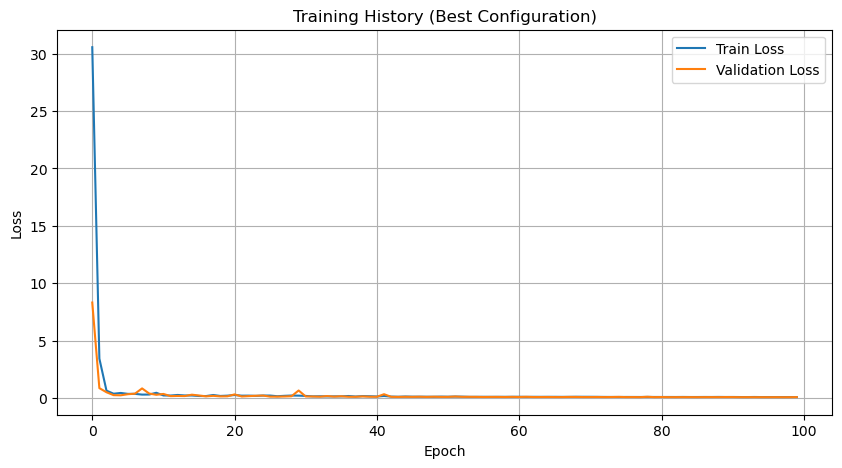


Best model saved at epoch 98 with validation loss 0.0627


In [ ]:
# Train final model with best configuration found from search
final_model = ParameterPredictor(best_config)
lossfcn = nn.MSELoss()

# Extract learning rate from best_config or use default
lr = best_config.get('learning_rate', 0.01)
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=lr)

final_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    final_optimizer,
    mode='min',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=True
)

# Train for more epochs since this is the final model
final_outputs = train_model(
    final_model, 
    final_optimizer, 
    lossfcn, 
    200,  # More epochs for final training
    train_loader, 
    val_loader, 
    patience=10,  # More patience for final model
    scheduler=final_scheduler,
    save_best_model=True,  # Save the best model checkpoint
    model_path='best_final_model.pt'  # Path to save the model
)

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(final_outputs['train_losses'], label='Train Loss')
plt.plot(final_outputs['val_losses'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History (Best Configuration)')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nBest model saved at epoch {final_outputs['best_val_epoch'] + 1} with validation loss {final_outputs['best_val_loss']:.4f}")

# Evaluation

In [18]:
# Load the best saved model for evaluation
eval_model, checkpoint = load_best_model('best_final_model.pt')

# Display the configuration of the loaded model
print("\nModel Configuration:")
for key, value in checkpoint['model_config'].items():
    print(f"  {key}: {value}")

Loaded model from best_final_model.pt
  Best epoch: 98
  Best validation loss: 0.0627

Model Configuration:
  lstm_hidden_size: 256
  lstm_num_layers: 1
  fc_layer_sizes: [256, 128]
  activation: relu
  dropout: 0.0
  learning_rate: 0.01


Test Set Performance (Best Saved Model):
  RMSE: 0.2599
  MAE: 0.1933
  R²: 0.9919


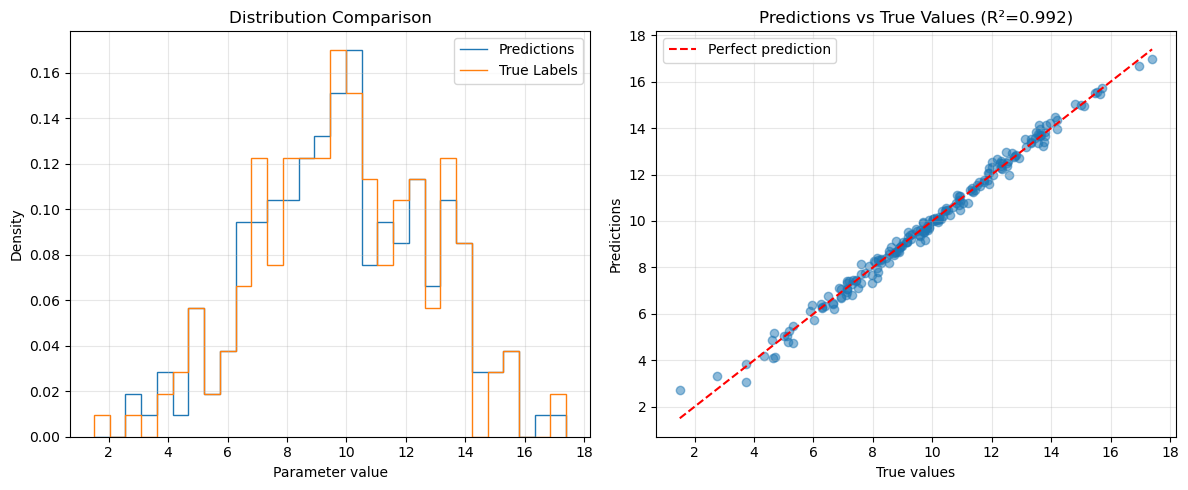

In [19]:
predictions = []
labels = []
rmse_list = []

# Use eval_model (loaded from checkpoint)
eval_model.eval()

for X_test, y_test in test_loader:
    test_predictions = eval_model(X_test).detach().numpy()
    test_targets = y_test.numpy()
    predictions.extend(test_predictions)
    labels.extend(test_targets)
    rmse = np.sqrt(np.mean((test_predictions - test_targets) ** 2))
    rmse_list.append(rmse)

# Calculate overall test metrics
test_metrics = calculate_metrics(np.array(predictions), np.array(labels))

print("Test Set Performance (Best Saved Model):")
print(f"  RMSE: {test_metrics['rmse']:.4f}")
print(f"  MAE: {test_metrics['mae']:.4f}")
print(f"  R²: {test_metrics['r2']:.4f}")

# Plot prediction vs true distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
l_counts, l_edges = np.histogram(labels, bins=30, density=True)
p_counts, p_edges = np.histogram(predictions, bins=l_edges, density=True)  # align bins with predictions
plt.stairs(p_counts, p_edges, label='Predictions', color='C0')
plt.stairs(l_counts, l_edges, label='True Labels', color='C1')
plt.xlabel('Parameter value')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot scatter: predictions vs true values
plt.subplot(1, 2, 2)
plt.scatter(labels, predictions, alpha=0.5)
plt.plot([min(labels), max(labels)], [min(labels), max(labels)], 'r--', label='Perfect prediction')
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title(f'Predictions vs True Values (R²={test_metrics["r2"]:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

random pycbc stuff

In [ ]:
# from pycbc.waveform import get_td_waveform

# hp, hc = get_td_waveform(approximant="IMRPhenomD", mass1=10,mass2=10,spin1z=0.9,delta_t=1/4096,f_lower=40)

# print(hp.sample_times)

Explanation by copilot, I am using too much ai :(

    LSTM — short summary

LSTM (Long Short‑Term Memory) is a recurrent neural unit designed to learn long‑range dependencies in sequences.
Core components: cell state (long‑term memory) and three gates — input (what to write), forget (what to drop), output (what to expose).
Gates are learned multiplicative filters (sigmoid activations) that control information flow, which prevents vanishing/exploding gradients for long sequences.
How the notebook uses an LSTM (concise mapping to your code)

Input shape: X comes in as [batch, seq_len] and the model does x = x.unsqueeze(-1) → [batch, seq_len, 1] so feature_dim=1 per timestep.
LSTM instantiation: nn.LSTM(input_size=1, hidden_size=..., num_layers=...) — this processes the time series and produces outputs at every timestep plus hidden/cell states.
last_out = lstm_out[:, -1, :] — the code takes the last timestep's LSTM output (a fixed-length vector summarising the sequence) and feeds it to a small fully connected head that outputs a single scalar parameter.
Training target: regression (MSE) to the scalar parameter (amplitude).
Is an LSTM the best approach for pulling out a single parameter?
Short answer: not necessarily — it depends on the problem, noise, waveform knowledge, and compute/data budget.

When LSTM is appropriate

Temporal ordering matters and the parameter depends on long‑range time relationships in a way that simple summary stats can't capture.
You have enough labelled training examples to learn those dependencies.
You want a learned, flexible sequence encoder that can handle variable‑length inputs (with care).
When something else is often better

If the goal is to extract a single global parameter (e.g., amplitude, phase, frequency) from a known deterministic signal in noise, classical signal processing or matched filtering is usually superior (optimal in Gaussian noise, efficient, and interpretable).
If you only need a robust scalar estimate and not to reproduce or model the waveform, much simpler/faster options work well:
Summary statistics (mean, variance), peaks in Fourier/periodogram, envelope detection.
Matched filtering / template fitting (especially for gravitational‑wave style waveforms).
1D CNN + global pooling (faster to train than LSTM, good at local patterns and translational invariance).
Linear / kernel regression on engineered features (FFT magnitudes, wavelet coefficients).
If you want uncertainty or a posterior

LSTM + deterministic head gives point estimates only. For uncertainties / posteriors:
Predict mean and log‑variance and train with Gaussian NLL loss.
Use MC dropout or deep ensembles for approximate uncertainty.
Use probabilistic models / normalizing flows / amortized inference for full posterior estimates (dingo, conditional density estimators).
Practical improvements you can make if you keep LSTM

Normalize input sequences (zero mean, unit variance per sample or dataset).
Downsample or window the sequence to shorten seq_len if signal is smooth.
Use global pooling over timesteps (mean/max) or attention over timesteps instead of only last timestep.
Consider a 1D CNN encoder (fewer parameters, faster) or hybrid CNN→LSTM (CNN extracts local features, LSTM aggregates).
Predict both value and uncertainty (e.g., output mu and log_sigma and train with negative log likelihood).
Recommendation (concise)

If you know the waveform shape and noise approximates Gaussian: use matched filtering or template fitting — best accuracy and interpretability.
If you want a learned estimator and have lots of labelled data: 1D CNN with global pooling or a small encoder + MLP (or CNN+attention) is usually faster and as effective as an LSTM for extracting a single scalar.
If you need uncertainties/posteriors, augment the model to predict variance or use probabilistic/ensemble methods.
If you want, I can:

Show a compact 1D‑CNN regressor example that maps sequence → scalar (faster than LSTM), or
Add uncertainty prediction to your LSTM head (mu, sigma) with Gaussian NLL loss.